In this project, I was assigned to do an in-depth analysis of airline performance using data sourced from Kaggle’s Data Expo 2009: Airline On-Time Data. The dataset spans U.S. domestic flight records from 1987 to 2008, but for the purposes of this analysis, we focus exclusively on the year 2007.

For this analysis, we utilize the following datasets: flights_2007 (originally 2007.csv), airports.csv, carriers.csv, and plane.csv. Descriptions of each dataset and their roles in the analysis are provided in the sections below.


***Table 1*: Flight Data `flights_2007`**

| **Attribute**         | **Description**                                                             |**Type**     |
|-----------------------|:----------------------------------------------------------------------------|:-----------:|
| Year                  | 1987–2008                                                                   |int          |
| Month                 | 12–Jan                                                                      |string       |
| DayofMonth            | 31–Jan                                                                      |string       |
| DayOfWeek             | 1 (Monday) – 7 (Sunday)                                                     |int          |
| DepTime               | actual departure time (local, hhmm)                                         |int          |
| CRSDepTime            | scheduled departure time (local, hhmm)                                      |int          |
| ArrTime               | actual arrival time (local, hhmm)                                           |int          |
| CRSArrTime            | scheduled arrival time (local, hhmm)                                        |int          |
| UniqueCarrier         | unique carrier code                                                         |int          |
| FlightNum             | flight number                                                               |int          |
| TailNum               | plane tail number                                                           |int          |
| ActualElapsedTime     | in minutes                                                                  |int          |
| CRSElapsedTime        | in minutes                                                                  |int          |
| AirTime               | in minutes                                                                  |int          |
| ArrDelay              | arrival delay, in minutes                                                   |int          |
| DepDelay              | departure delay, in minutes                                                 |int          |
| Origin                | origin IATA airport code                                                    |string       |
| Dest                  | destination IATA airport code                                               |string       |
| Distance              | in miles                                                                    |int          |
| TaxiIn                | taxi in time, in minutes                                                    |int          |
| TaxiOut               | taxi out time, in minutes                                                   |int          |
| Cancelled             | was the flight cancelled?                                                   |bool         |
| CancellationCode      | reason for cancellation (A = carrier, B = weather, C = NAS, D = security)   |string       |
| Diverted              | 1 = yes, 0 = no                                                             |bool         |
| CarrierDelay          | in minutes                                                                  |int          |
| WeatherDelay          | in minutes                                                                  |int          |
| NASDelay              | in minutes                                                                  |int          |
| SecurityDelay         | in minutes                                                                  |int          |
| LateAircraftDelay     | in minutes                                                                  |int          |


***Table 2*: Carrier Data / Airline `carriers`**

| **Attribute**         | **Description**                                                             |**Type**     |
|-----------------------|:----------------------------------------------------------------------------|:-----------:|
| code                  | Carrier Code                                                                |string       |
| description           | Carrier Name                                                                |string       |


***Table 3*: Airport Data `airports`**

| **Attribute**         | **Description**                                                             |**Type**     |
|-----------------------|:----------------------------------------------------------------------------|:-----------:|
| airport                  | Airport Name                                                             |string       |
| city                     | Airport City                                                             |string       |
| country                  | Airport Country                                                          |string       |
| iata                     | Airport Code                                                             |string       |
| lat                      | Aiport Latitude                                                          |float        |
| long                     | Airport Longitude                                                        |float        |
| state                    | Airport State                                                            |string       |


***Table 4*: Aircraft Data `plane_data`**

| **Attribute**         | **Description**                                                             |**Type**     |
|-----------------------|:----------------------------------------------------------------------------|:-----------:|
| tailnum               | Aircraft Tail Number                                                        |string       |
| type                  | Usage Type                                                                  |string       |
| manufacturer          | Manufacturer Company                                                        |string       |
| issue_date            | Date Start Operating                                                        |string       |
| model                 | Aircraft Model                                                              |string       |
| status                | Status                                                                      |string       |
| aircraft_type         | Aircraft Type                                                               |string       |
| engine_type           | Engine Type                                                                 |string       |
| year                  | Manufacture Year                                                            |string       |


**This project aims to address the following key questions:**

**What are the temporal trends in flight delays and cancellations?**
Analyze patterns based on time dimensions (hourly, daily, and monthly) to identify when delays and cancellations most frequently occur.

**What are the main contributing factors to flight delays and cancellations?**
Examine the types of delays (weather, carrier-related, NAS) in terms of both frequency and average duration to understand their impact on flight operations.

**Which routes experience the highest operational issues, and why?**
Identify problematic routes with high cancellation or delay rates and investigate potential underlying causes.

We can start the project with steps that is method of managing the database.

## Importing Data to HDFS and HIVE Database

In [1]:
# Import libraries
# Load libraries for data manipulation and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from impala.dbapi import connect



# Set matplotlib style
plt.style.use('ggplot')

# Ignore warnings for cleaner coding
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Create a connection to the Hive database using Impala
cursor = connect(
    host='127.0.0.1',
    port = 10000,
    user = 'maria_dev',
    database = 'flights_data',
    auth_mechanism = 'PLAIN'
).cursor()

# Execute a query to show all tables in the database    
cursor.execute('SHOW TABLES')
print(cursor.fetchall())

[('airports',), ('carriers',), ('flights_2003',), ('flights_2007',), ('plane_data',)]


We can see the data that is in the database which is "airports", "carriers", "flight_2007", "plane_data" and "flights_2003". The 2003 data was also included since after going thru it one time, I decided to do 2007 rather than 2003 based on certain reasons.

In [3]:
# Wrap the data pulling process in a function for reusability
def pull_data(command):
    conn = connect(
        host='127.0.0.1',
        port=10000,
        user='maria_dev',
        database='flights_data',
        auth_mechanism='PLAIN'
    )
    cursor = conn.cursor()
    cursor.execute(command)
    data = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]
    df = pd.DataFrame(data, columns=columns)
    df.columns = df.columns.str.replace('^.*\.', '', regex=True)
    return df

## 1. Delay Patterns

### What times of day (morning/afternoon/evening) have the lowest average delays?

To start off, for the first analysis, we will be examining which time of day has the lowest average delays. We will need to define the dataset into 4 timeframes:

+   5am - 11.59am : Morning
+  12pm - 4.59pm : Afternoon
+  5pm - 8.59pm : Evening
+  9pm - 4.59 am : Night

There are two types of delays in airline, **departure delays** and **arrival delays**. We will be looking at both in this section. While arrival delays don't have much of an effect, departure delays are more relevant to rider experience, and actually often demonstrate more about schedule handling involving airlines and airport compared to arrival delays which can be out of the pilot's hands.

In [4]:
query1 = '''
SELECT
  TimeOfDay,
  AVG(ArrDelay) AS AvgArrivalDelay,
  AVG(DepDelay) AS AvgDepartureDelay
FROM (
  SELECT *,
    CASE
      WHEN CRSDepTime BETWEEN 500 AND 1159 THEN 'Morning'
      WHEN CRSDepTime BETWEEN 1200 AND 1659 THEN 'Afternoon'
      WHEN CRSDepTime BETWEEN 1700 AND 2059 THEN 'Evening'
      ELSE 'Night'
    END AS TimeOfDay
  FROM flights_2007
  WHERE Cancelled = 0
) AS categorized
WHERE TimeOfDay IS NOT NULL
GROUP BY TimeOfDay
ORDER BY AvgArrivalDelay ASC
'''


df1 = pull_data(query1)

df1


,timeofday,avgarrivaldelay,avgdeparturedelay
0,Morning,1.369262,3.025810
1,Night,6.615511,9.103326
2,Afternoon,6.738063,7.891461
3,Evening,10.306314,11.920471


In [5]:
# Sort time of day by custom order
time_order = ['Morning', 'Afternoon', 'Evening', 'Night']
df1 = df1.groupby('timeofday', observed=True).agg(
    avgarrivaldelay=('avgarrivaldelay', 'mean'),
    avgdeparturedelay=('avgdeparturedelay', 'mean')
).reindex(time_order)

df1

,avgarrivaldelay,avgdeparturedelay
timeofday,,
Morning,1.369262,3.025810
Afternoon,6.738063,7.891461
Evening,10.306314,11.920471
Night,6.615511,9.103326


The query data has been sorted according to time of day.

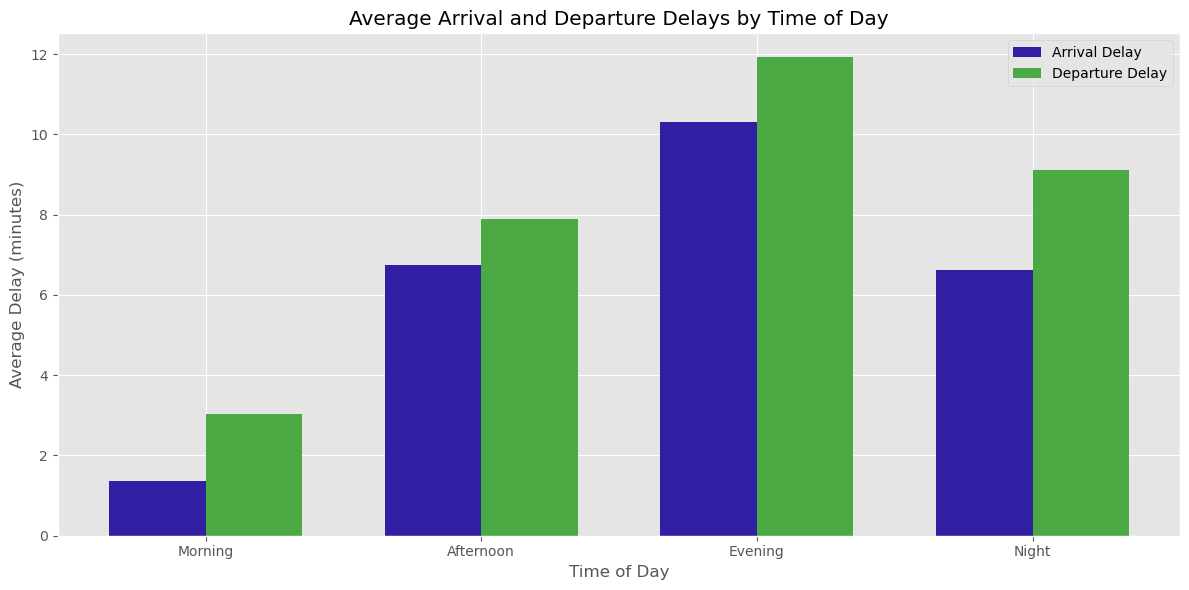

In [6]:
plt.figure(figsize=(12, 6))

# Set width of bars
x = np.arange(len(time_order))
width = 0.35

# Create the two bars side by side
plt.bar(x - width/2, df1['avgarrivaldelay'], width, label='Arrival Delay', color="#311FA3")
plt.bar(x + width/2, df1['avgdeparturedelay'], width, label='Departure Delay', color="#4BAA44")

# Add labels, title and legend
plt.xlabel('Time of Day')
plt.ylabel('Average Delay (minutes)')
plt.title('Average Arrival and Departure Delays by Time of Day')
plt.xticks(x, time_order)
plt.legend()

plt.tight_layout()
plt.show()

The graph shown above demonstrates a consistent pattern of relation between arrival and departure delays at various times of day. As is fairly consistent in aviation, departure delays tend to be slightly worse than arrival delays. This difference can be attributed to several operational factors, including late arriving aircraft, longer ground handling times, and traffic congestion during takeoff scheduling. Studies have shown that departure delays are often more severe because they propagate from previous flights and are impacted by gate availability, crew readiness, and airport congestion at peak hours (Mueller & Chatterji, 2002; Wang et al., 2020).

Next, the bar chart also illustrates that the time of day has a huge impact on delay durations. In the early morning time slot, flights have the least amount of delays, with arrival delays of around 1.4 minutes and departure delays around 3 minutes. Thus, we can see that morning flights are the best time to fly. Delay durations increase continuously from this time slot until evening where it reach its peak, this can be seen when arrival delay for evening ranges from slightly more than 10 minutes and departure delay is just below 12 minutes. Night flights also have delays, however, they are still somewhat below the delays of the evening level. It can be concluded from this graph that delays accumulated through the day, which reinforces the fact that flying in the morning time slot is advantageous. For passengers and airlines alike, this highlights the benefit of morning flights for more reliable flight on time performance.

References.

Mueller, E., & Chatterji, G. B. (2002). Analysis of aircraft arrival and departure delay characteristics. American Institute of Aeronautics and Astronautics. https://aviationsystems.arc.nasa.gov/publications/more/analysis/mueller_10_02.pdf

Wang, Y.-J., Cao, Y.-K., Zhu, C.-P., Wu, F., Hu, M.-H., & Stanley, H. E. (2020). Universal patterns in passenger flight departure delays. Scientific Reports, 10, Article 12871. https://www.nature.com/articles/s41598-020-62871-6

### Which days of the week show better on-time performance?

In [7]:
query2 = '''
SELECT
  DayOfWeek,
  AVG(ArrDelay) AS AvgArrivalDelay,
  AVG(DepDelay) AS AvgDepartureDelay
FROM flights_2007
WHERE Cancelled = 0
GROUP BY DayOfWeek
ORDER BY DayOfWeek DESC
'''

df2 = pull_data(query2)
df2

,dayofweek,avgarrivaldelay,avgdeparturedelay
0,7,5.720269,7.733987
1,6,1.967627,5.285488
2,5,7.607582,8.479235
3,4,7.223630,7.864381
4,3,5.043470,6.156405
5,2,4.048911,5.558705
6,1,5.787095,7.313615


In [8]:
# Map and sort the days of the week

df2 = df2.sort_values('dayofweek')
df2['dayofweek'] = df2['dayofweek'].map({1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'})
df2

,dayofweek,avgarrivaldelay,avgdeparturedelay
6,Monday,5.787095,7.313615
5,Tuesday,4.048911,5.558705
4,Wednesday,5.043470,6.156405
3,Thursday,7.223630,7.864381
2,Friday,7.607582,8.479235
1,Saturday,1.967627,5.285488
0,Sunday,5.720269,7.733987


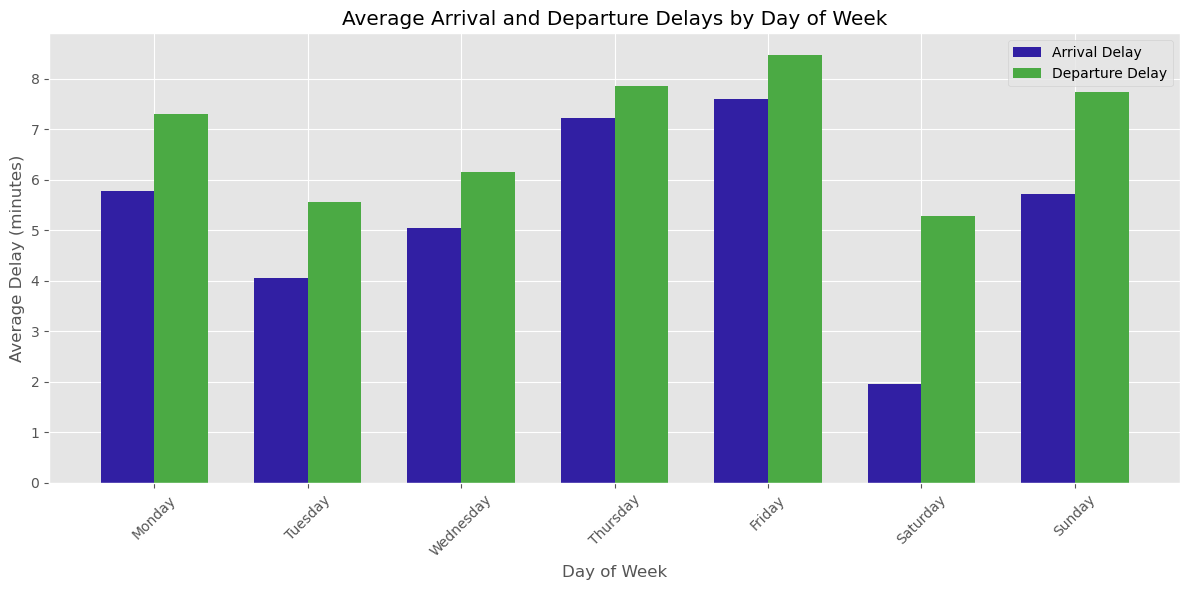

In [9]:
# Plotting the average arrival and departure delays by time of day
plt.figure(figsize=(12, 6))

# Set width of bars
x = np.arange(len(df2['dayofweek']))
width = 0.35

# Create the two bars side by side
plt.bar(x - width/2, df2['avgarrivaldelay'], width, label='Arrival Delay', color='#311FA3')
plt.bar(x + width/2, df2['avgdeparturedelay'], width, label='Departure Delay', color='#4BAA44')

# Add labels, title and legend
plt.xlabel('Day of Week')
plt.ylabel('Average Delay (minutes)')
plt.title('Average Arrival and Departure Delays by Day of Week')
plt.xticks(x, df2['dayofweek'], rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

The bar chart represents the average arrival and departure delays on each day of the week in the USA for the year 2007. It seems that delays do not occur at random throughout the week. We can observe a clear pattern, and all of the evidence clearly indicates that Friday, as a general rule, tends to have delays that is more than other days of the week, as this is represented by an average departure delay of more than 8 minutes as well as an average arrival delay of approximately 7.5 minutes.  The rise in delays is likely associated with the high volumes of business and leisure travelers going home for a weekend at the end of their work week resulting in congestion at airports and in air traffic flow. Thursday have delay compareable to Friday, where Thursday have almost similar delay times as group of travelers sometimes use the day to engage in weekend travel and to begin the huge volume of activity the following day.

In contrast, Saturday has the least average arrival delays at just over 2 minutes, implying much less stress on the air traffic system. This is probably not coincidental as Saturday has fewest business travelers, and few scheduled flights. Furthermore, it is interesting to find that arrival delays are low on Saturday, while departure delays were still somewhat at a moderate level, which could indicate a lack of scheduling efficiency, or some subsequent effects of delays of past days.

For the most part, the data suggests that weekdays and weekends characterized quite different flight performance behaviors. For weekdays especially Thursday and Friday, flight performance had greater risks of delays because of heavy traffic loadings, scheduling efficiency, and compounding effects of delays of prior flights. On the other hand, weekends achieved greater on time performance rates with Saturday being the best day in the study based on time arrival rates overall. This is an important categorical finding for travelers, where they can time their traveliing date. In conclusion, traveling earlier in the week and on weekends provides increased chances of reliability in flight tentative.


### During which months or seasons are flights most likely to be on time?

We determined that Saturday provides a good compromise of arrival and departure delays. Next, we can scale it to see which months/seasons has the best on time performance.

As this dataset is from the US, we have to use the months to track the distribution of the seasons as;

+ Winter : Dec, Jan, Feb
+ Spring : March, Apr, May
+ Summer : June, Jul, Aug
+ Autumn : Sept, Oct, Nov

Now we can look at the performance of both arrival and departure delays again based on seasons.

In [13]:
query3 = '''
SELECT
  Month,
  CASE
    WHEN month in (12,1,2) THEN "Winter" 
    WHEN month in (3,4,5) THEN "Spring"
    WHEN month in (6,7,8) THEN "Summer"
    WHEN month in (9,10,11) THEN "Autumn"
  END AS Season,
  AVG(ArrDelay) AS AvgArrivalDelay,
  AVG(DepDelay) AS AvgDepartureDelay
FROM flights_2007
WHERE Cancelled = 0
GROUP BY Month
ORDER BY Month ASC
'''

df3 = pull_data(query3)
df3

,month,season,avgarrivaldelay,avgdeparturedelay
0,1,Winter,4.073282,5.874702
1,2,Winter,8.056957,8.809941
2,3,Spring,4.576819,6.547126
3,4,Spring,2.090118,4.932755
4,5,Spring,3.139034,5.101466
5,6,Summer,7.296114,8.427428
6,7,Summer,8.618457,9.584318
7,8,Summer,8.429837,9.258237
8,9,Autumn,1.692992,3.697959
9,10,Autumn,2.320786,4.351005


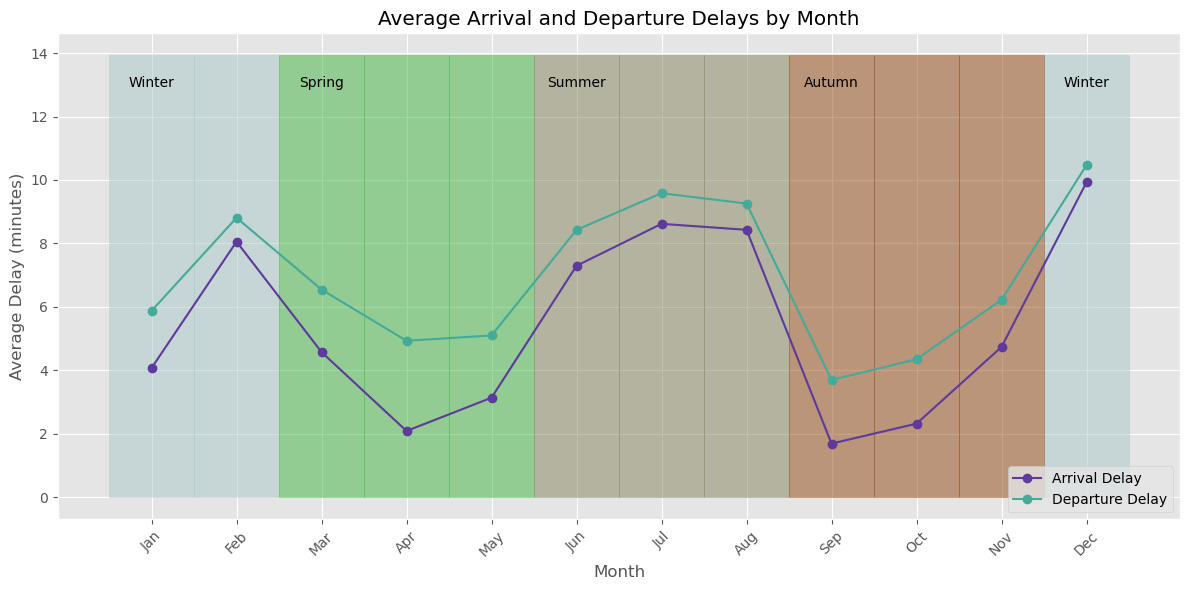

In [14]:
# Plot line chart for average arrival and departure delays by month
plt.figure(figsize=(12, 6))

plt.plot(df3['month'], df3['avgarrivaldelay'], marker='o', label='Arrival Delay', color='#5D3A9B')
plt.plot(df3['month'], df3['avgdeparturedelay'], marker='o', label='Departure Delay', color='#44AA99')

# Season colors
season_colors = {
    'Winter': "#A8C8C8",  # Light blue
    'Spring': "#40B540",  # Light green
    'Summer': "#82825A",  # Light yellow
    'Autumn': "#91470E"     # Light orange/peach
}

# Create a list to store legend elements
legend_elements = []

# Get the maximum y-value for the fill (slightly above the max delay)
max_y = df3['avgarrivaldelay'].max() + 4

# Add seasonal shading with improved approach to avoid gaps
for season in df3['season'].unique():
    # Extract month values where season matches
    season_data = df3[df3['season'] == season]
    
    # Create extended x values for each month to create blocks
    for _, row in season_data.iterrows():
        month = row['month']
        # Create rectangular blocks by extending 0.5 in both directions
        x_rect = [month - 0.5, month + 0.5, month + 0.5, month - 0.5]
        y_rect = [0, 0, max_y, max_y]
        
        plt.fill(x_rect, y_rect, color=season_colors[season], alpha=0.5, zorder=1)
    
    # Add to legend elements (only once per season)
    from matplotlib.patches import Patch
    legend_elements.append(Patch(facecolor=season_colors[season], alpha=0.5, label=season))

# Add lines to legend elements
line_elements = plt.gca().get_legend_handles_labels()[0]
legend_elements = line_elements + legend_elements

# Add text labels for seasons for better visibility
plt.text(1, max_y-1, 'Winter', fontsize=10, color='black', ha='center')
plt.text(3, max_y-1, 'Spring', fontsize=10, color='black', ha='center')
plt.text(6, max_y-1, 'Summer', fontsize=10, color='black', ha='center')
plt.text(9, max_y-1, 'Autumn', fontsize=10, color='black', ha='center')
plt.text(12, max_y-1, 'Winter', fontsize=10, color='black', ha='center')

plt.xlabel('Month')
plt.ylabel('Average Delay (minutes)')
plt.title('Average Arrival and Departure Delays by Month')
plt.xticks(df3['month'], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


The line graph show a monthly summary of average flight delays in the U.S for the 12 months of 2007, giving it a seasonal perspective using colour to display season. The data indicates delays patterning are higher in summer and winter months when compared to spring and fall months bypassing delays above average trends. The summer months specifically July and August peak in average delays,  where for departures almost to ten minutes and arrivals around eight minutes. This is likely a result of the significantly larger amount of passengers traveling during the busy summer vacation season with vacationers and families often choosing to fly, with airports hitting thresholds of congested flights pilling up. There is also the added effect of summer thunderstorms and convective weather disturbances, which are common in many regions of the U.S. during the warmer months. These weather events significantly complicate airline schedules by reducing visibility, slowing down airport operations, and causing air traffic rerouting and ground delays (Federal Aviation Administration [FAA], 2020; National Weather Service [NWS], 2019).

December is a month that sees a spike in delays, probably due to holiday travel with greater travel demand around Christmas and New Year's where holidays recently taken off. This means there are not only high passenger loads, but also heavy snowstorms that create delays and cancellations such as snowstorms and icy runways (Federal Aviation Administration [FAA], 2020; National Weather Service [NWS], 2019). This accumulate delays to a bigger problem for longer period of time. So based on the combined pressures of greater travel demand and climatic pressures especially for this monthly context, a holday trips or business travels can be problematic because of aiport errors and overall delays. This is why December is also one of the worst month for delay performance.

The autumn months of September, October, and November, have a much lower average of delays. This can be seen especially in September, which has months with estimated average delays below 4 minutes. Hence, September represents the month with the lowest average delay, and the most travel on time performance (Federal Aviation Administration [FAA], 2020; National Weather Service [NWS], 2019). Lower average delays can be attributed to the moderate amount of travel that happens post summer holidays and the generally good weather associated with these months overall. The main cause of lower average delays are the lower probabilities of disrupted travel by event such as summer holidays, the lower probability of bad weather disruptions to travel, thus therefore a more consistent travel quality.

In general, the data presented in the graph represents seasonal impacts on delays. Travelers can expect longer delays during peak demand periods and hazardous weather like summer and winter. However the months of autumn will be the best conditions in a the sense of timing to depart and arrive on time. This is helpful information for travelers who are looking to plan travel from the angle of decreasing the chances of a scheduling troubles by flying in off peak months.

References.

Federal Aviation Administration. (2020). Weather causes of flight delays. U.S. Department of Transportation. https://www.faa.gov/newsroom/weather-causes-flight-delays

National Weather Service. (2019). Thunderstorms and air travel. NOAA. https://www.weather.gov/safety/thunderstorm-airtravel

## 2. Delay Factors

### Identify and rank the top 3-5 factors contributing to flight delays, based on the delay categories provided in the dataset and quantify the impact of each factor (in minutes of delay and percentage of total delays).

It is best to avoid delays that are out of your control like weather or season, however sometimes it is not practical to select certain best travel times because of holiday times, work obligations, and flights or services which have laxity in offered days of service or frequency. Therefore, it is important to know what is typically the cause of flight delays in the dataset. The largest contributing factors or the primary components trying to cause delays are: 

1. Late Aircraft Delay
1. Weather Delay
1. Carrier Delay
1. NAS (National Airspace System) Delay
1. Security Delay 

To answer this question for the purposes of enhancing travel knowledge, it is important to gain more knowledge on how various delay causation affect overall delay time. For example the traveler can found if there is a delay due to weather or airline operational factor, where travelers can understands the delays situation. Those understanding helps travelers to plan through their choice of travel with a more efficient airlines, or changing their travel planning if it practical to accommodate for average delays.

In [15]:
query4 = '''
SELECT
  DelayType,
  AvgDelayMinutes,
  IncidentCount
FROM (
  SELECT 'CarrierDelay' AS DelayType,
         AVG(CarrierDelay) AS AvgDelayMinutes,
         SUM(CASE WHEN CarrierDelay > 0 THEN 1 ELSE 0 END) AS IncidentCount
  FROM flights_2007
  WHERE CarrierDelay > 0

  UNION ALL

  SELECT 'WeatherDelay',
         AVG(WeatherDelay),
         SUM(CASE WHEN WeatherDelay > 0 THEN 1 ELSE 0 END)
  FROM flights_2007
  WHERE WeatherDelay > 0

  UNION ALL

  SELECT 'NASDelay',
         AVG(NASDelay),
         SUM(CASE WHEN NASDelay > 0 THEN 1 ELSE 0 END)
  FROM flights_2007
  WHERE NASDelay > 0

  UNION ALL

  SELECT 'SecurityDelay',
         AVG(SecurityDelay),
         SUM(CASE WHEN SecurityDelay > 0 THEN 1 ELSE 0 END)
  FROM flights_2007
  WHERE SecurityDelay > 0

  UNION ALL

  SELECT 'LateAircraftDelay',
         AVG(LateAircraftDelay),
         SUM(CASE WHEN LateAircraftDelay > 0 THEN 1 ELSE 0 END)
  FROM flights_2007
  WHERE LateAircraftDelay > 0
) AS DelaySummary
ORDER BY AvgDelayMinutes DESC
LIMIT 5
'''
df4 = pull_data(query4)
df4

,delaytype,avgdelayminutes,incidentcount
0,WeatherDelay,44.710400,261709
1,LateAircraftDelay,42.884911,1588743
2,CarrierDelay,35.033495,1556033
3,NASDelay,27.294427,2337116
4,SecurityDelay,20.444873,20489


In [35]:
df4['incident_percent'] = df4['incidentcount'] / df4['incidentcount'].sum() * 100
df4['incident_percent'] = df4['incident_percent'].round(2)

df4

,delaytype,avgdelayminutes,incidentcount,incident_percent
0,WeatherDelay,44.710400,261709,4.54
1,LateAircraftDelay,42.884911,1588743,27.56
2,CarrierDelay,35.033495,1556033,27.00
3,NASDelay,27.294427,2337116,40.55
4,SecurityDelay,20.444873,20489,0.36


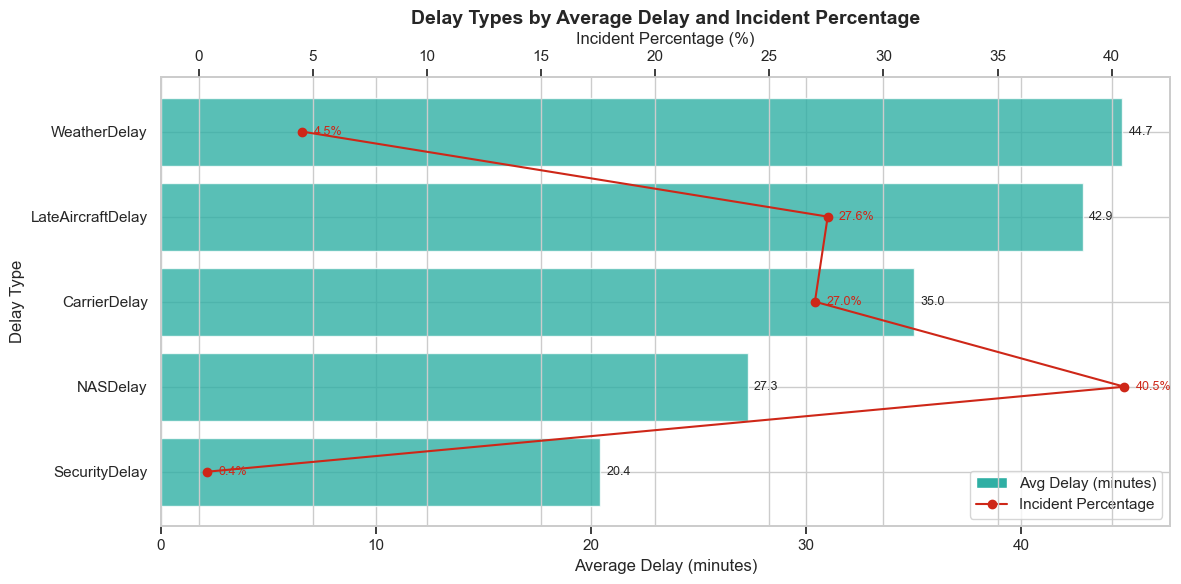

In [42]:
# Optional: sort by avgdelayminutes
df4_sorted = df4.sort_values(by='avgdelayminutes', ascending=True)

# Set seaborn style
sns.set_theme(style='whitegrid')

# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Horizontal bar for average delay minutes
bars = ax.barh(df4_sorted['delaytype'], df4_sorted['avgdelayminutes'], color='#2FAFA4', alpha=0.8)

# Twin axis for incident percentage
ax2 = ax.twiny()

# Line plot for incident percentage
line = ax2.plot(df4_sorted['incident_percent'], df4_sorted['delaytype'], 'o-', color='#CE2718', label='Incident Percentage')

# Axis labels and title
ax.set_xlabel('Average Delay (minutes)', fontsize=12)
ax2.set_xlabel('Incident Percentage (%)', fontsize=12)
ax.set_ylabel('Delay Type')
ax.set_title('Delay Types by Average Delay and Incident Percentage', fontsize=14, fontweight='bold')

# Custom legend
legend_elements = [
    Patch(facecolor="#2FAFA4", label='Avg Delay (minutes)'),
    plt.Line2D([0], [0], marker='o', color="#CE2718", label='Incident Percentage')
]
ax.legend(handles=legend_elements, loc='lower right')

# Annotate bar values (avg delay)
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.3, bar.get_y() + bar.get_height()/2, f'{width:.1f}', va='center', fontsize=9)

# Annotate line values (incident percentage)
for i, (x, y) in enumerate(zip(df4_sorted['incident_percent'], df4_sorted['delaytype'])):
    ax2.text(x + 0.5, y, f'{x:.1f}%', va='center', fontsize=9, color='#CE2718')

plt.tight_layout()
plt.show()

The graph above clearly shows difference in the minutes of delays with delay types. Specifically, 40.5 percent of all delays were due to NAS delays, which includes other delays such as Air Traffic delays and congestion, routing delays, airport operations (Federal Aviation Administration [FAA], 2021). All of these events are considered NAS related delay with a short term delay of around 27 minutes is still considered. Although NAS (National Airspace System) delays are common, they often do not offer specific or actionable information that airlines can use to make operational decisions. There are times when NAS delays can often be resolved quicker than other delay types such as with rerouting, adjustments to how advertised departure and arrival times.

Late Aircraft delay are the second biggest contributor to the percentage of a flight delay, with an average delay of 42.9 minutes, and account for 27.6% of incidents. This type of delay is referred to when an aircraft is reported late arrivals, causing the next scheduled departure to be delayed. The degree of delay according to the average delay is probably caused by more than one impacted sequential departure causing compounding effects. Considering the frequency of the incident and its average duration, it is safe to say that they are ranked as one of the larger impacts on flight schedules, especially when considering scheduling with limited time between flights.

Carrier related delays are the next common reason for delays accounting for 27% of all delay incidents with an average delay of 35.0 minutes. Carrier related delays are supposed to be control by the airline as they happen from crew unavailability, undiagnosed maintenance issues, and loading/unloading issues (U.S. Department of Transportation [DOT], 2023). While carrier delays are not the most common or the longest delays contributed, carrier delay still presents the most troublesome operational limitation the airline faces since these delays are entirely internal or in house and could be managed better through resourcing to help reduce the pressure on carriers.

On the other hand, weather related delays result from extreme weather conditions, such as thunderstorms, snow, fog, or wind, impacting approximately 5% of delays overall. However weather delays have a much larger impact for those affected, with an average delay of about 45 minutes which is almost twice of NAS delays due to the inflexibility and safety precautions associated with operating flights in severe weather. Unlike NAS, weather does not allow for re routing or re scheduling options, and often the only feasible and safer options are to cancel the flight or impose long ground delay until a better opportunity for safer weather travels occurs. Furthermore, weather delays impact not only the flight specifically, but potentially several other flights at different airports that may or may not directly relate to the specific flight and several underlying time slots may also have been delayed.

Security delays are rare (0.4%) and average of 20.4 minutes. Security delays can happen from protocols, enhanced security checks, and alerting terminal level security incidents(Federal Aviation Administration [FAA], 2023). While those delays do exist, in general, they occur rarely and are only for a while. They are still important operationally sensitive but have little aggregate impact.

Referencs.

Federal Aviation Administration. (2021). Understanding delay types in the National Airspace System. U.S. Department of Transportation. https://www.faa.gov/about/initiatives/delays

U.S. Department of Transportation. (2023). Airline delay causes. Bureau of Transportation Statistics. https://www.transtats.bts.gov/ot_delay/ot_delaycause1.asp?type=3&pn=1



A table summarize the analysis can be observed below.

| **Rank** | **Delay Type**          | **Incident Percentage (%)** | **Average Delay (Minutes)** | **Remarks**                                                                |
| -------- | ----------------------- | --------------------------- | --------------------------- | -------------------------------------------------------------------------- |
| 1        | **NAS Delay**           | **40.5%**                   | **27.3 min**                | Most frequent delay type with moderate duration                            |
| 2        | **Late Aircraft Delay** | 27.6%                       | 42.9 min                    | High delay duration compounding from inbound flight delays                 |
| 3        | **Carrier Delay**       | 27.0%                       | 35.0 min                    | Airline controlled issues (crew, maintenance) with fairly long duration    |
| 4        | **Weather Delay**       | 4.5%                        | **44.7 min**                | Least frequent, but longest average delay due to safety and weather issues |
| 5        | **Security Delay**      | 0.4%                        | 20.4 min                    | Rare, short delays from airport security screenings                        |


## 3. Cancellation Analysis

### Identify the primary reasons for flight cancellations as categorized in the dataset.

One other characteristic that can be used to identify poorly performing flights is cancellations. Now that we have looked at what delay patterns exist and their causes, let's look at cancellations. In the information part of the data set, the cancellation codes are very similar to the delay codes with Late Aircraft as the only one excluded. 

The reasons for cancellation are as follows:

1. Weather 
2. Carrier 
3. NAS (National Airspace System)
4. Security

In [54]:
query5 = '''
SELECT
  CASE
    WHEN CancellationCode = 'A' THEN 'Carrier'
    WHEN CancellationCode = 'B' THEN 'Weather'
    WHEN CancellationCode = 'C' THEN 'NAS'
    WHEN CancellationCode = 'D' THEN 'Security'
    ELSE 'Unknown'
  END AS cancellation_code,
  COUNT(*) AS count_cancellation
FROM flights_2007
WHERE Cancelled = 1
GROUP BY
  CASE
    WHEN CancellationCode = 'A' THEN 'Carrier'
    WHEN CancellationCode = 'B' THEN 'Weather'
    WHEN CancellationCode = 'C' THEN 'NAS'
    WHEN CancellationCode = 'D' THEN 'Security'
    ELSE 'Unknown'
  END
ORDER BY count_cancellation DESC
'''

df5 = pull_data(query5)
df5

,cancellation_code,count_cancellation
0,Unknown,145629
1,Carrier,133985
2,Weather,111393
3,NAS,73551
4,Security,597


There is lot of unknown or NA in the table implying of missing data for cancelation code

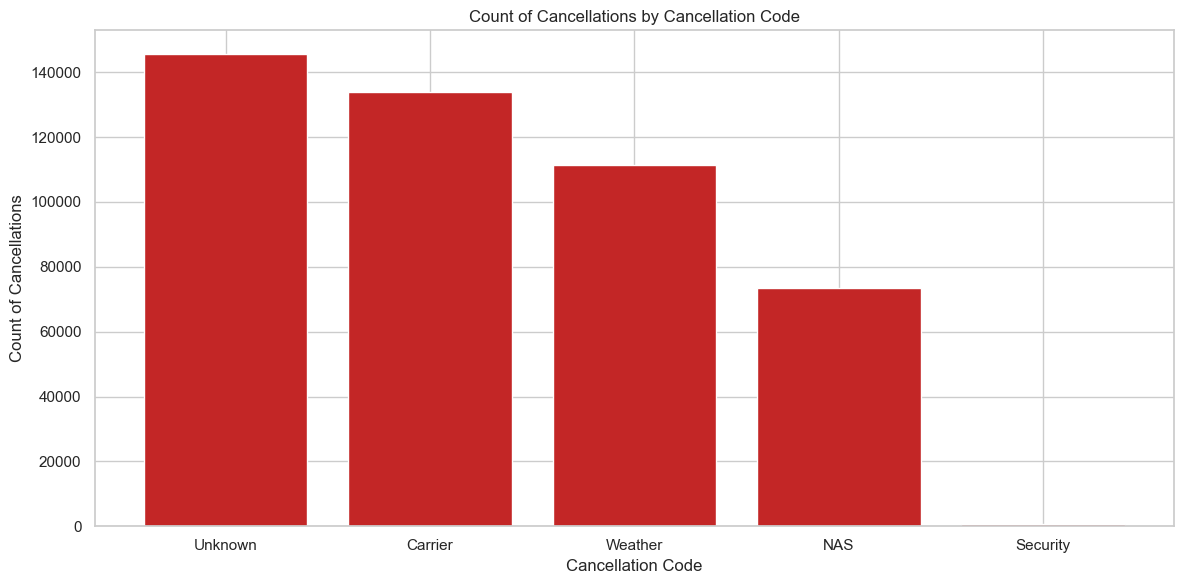

In [55]:
# Plot the count of cancellations by cancellation code
plt.figure(figsize=(12, 6))
plt.bar(df5['cancellation_code'], df5['count_cancellation'], color="#C32626")
plt.xlabel('Cancellation Code')
plt.ylabel('Count of Cancellations')
plt.title('Count of Cancellations by Cancellation Code')
plt.tight_layout()
plt.show()

The dataset on flight cancellations other than those categorized as “unknown” demonstrates that the airline carrier is the most common type of reason for cancellations. The "carrier" category has the largest proportion of known cancellations, demonstrating that the airline's own internal operations is a common reason for cancellations. They are likely to include a variety of problems in involving the primary "carrier" label alone, such as crew report availability, mechanical issues, maintenance, schedule conflicts. All of this are label with the label "carrier".

After "carrier", "weather" is the second most frequent contributor to cancellations. This is because of extreme weather for example winter storm, fog or hurricane can cause operational to cancel flight operations or re route flights to ensure personnel and customer safety. Weather cancellations while less frequent than delays, typically affect large numbers of flights for short times during extreme weather events and often cause a compounding system wide disruption (National Weather Service, 2022).

The National Airspace System (NAS), which includes traffic control delays was the third highest cause for cancellations. For "NAS" reasons, they are often associated with delays, but they can also lead to cancellations if the situation is significant enough to warrant cancelling a flight such as a breakdown to the air traffic system at a major hub or a major air traffic jam throughout the air traffic system would support cancellations (Federal Aviation Administration [FAA], 2023). 

Cancellations due to security reasons are rare but still counted for. Cancellations due to security stated reasons, are usually related to a serious event or an emergency disruption to the airport due to a security event or situation (Bureau of Transportation Statistics [BTS], 2023). Nevertheless, cancellations due to security disruptions, while rare, could mean that the airport could be relatively inactive in the operations area for or extended amount of time. This events could unfold because of situations such as a terminal evacuation or an extensive security investigation.

In conclusion, the analysis of known flight cancellation causes reveals that airline controlled operational issues ("carrier") are the most frequent contributors, highlighting internal inefficiencies such as crew or maintenance problems. Weather related cancellations, though less frequent, tend to create widespread disruption during severe events. NAS related cancellations stem from broader air traffic control or infrastructure issues, while security related cancellations, though rare, can lead to significant operational halts. This emphasizes the need for improved operational resilience, weather preparedness, and system coordination across all sectors of aviation.


References.

National Weather Service. (2022). Impact of weather on aviation. NOAA. https://www.weather.gov/aviation

Federal Aviation Administration. (2021). Understanding delay types in the National Airspace System. U.S. Department of Transportation. https://www.faa.gov/about/initiatives/delays

Bureau of Transportation Statistics. (2023). Understanding flight delays and cancellations. U.S. Department of Transportation. https://www.transtats.bts.gov/

Next, let look at airport with the highest cancellation rate for 2007.

In [21]:
df12 = """
SELECT 
  a.airport AS airport_name,
  a.city,
  COUNT(*) AS total_departures,
  SUM(f.cancelled) AS cancelled_flights,
  ROUND(SUM(f.cancelled) * 100.0 / COUNT(*), 2) AS cancellation_rate
FROM flights_2007 f
JOIN airports a
  ON f.Origin = a.iata
GROUP BY a.airport, a.city
HAVING COUNT(*) > 1000  -- filter out low-traffic airports
ORDER BY cancellation_rate DESC
LIMIT 10
"""

df12 = pull_data(df12)
df12


,airport_name,city,total_departures,cancelled_flights,cancellation_rate
0,Unalaska,Unalaska,2067,501,24.24
1,Aspen-Pitkin Co/Sardy,Aspen,5305,556,10.48
2,Capital,Springfield,1745,134,7.68
3,Kodiak,Kodiak,2869,210,7.32
4,James C. Johnson Petersburg,Petersburg,2904,196,6.75
5,Friedman Memorial,Hailey,12811,826,6.45
6,Flagstaff Pulliam,Flagstaff,1911,121,6.33
7,Dillingham,Dillingham,1024,64,6.25
8,Visalia Municipal,Visalia,2607,153,5.87
9,Central Wisconsin,Mosinee,1773,102,5.75


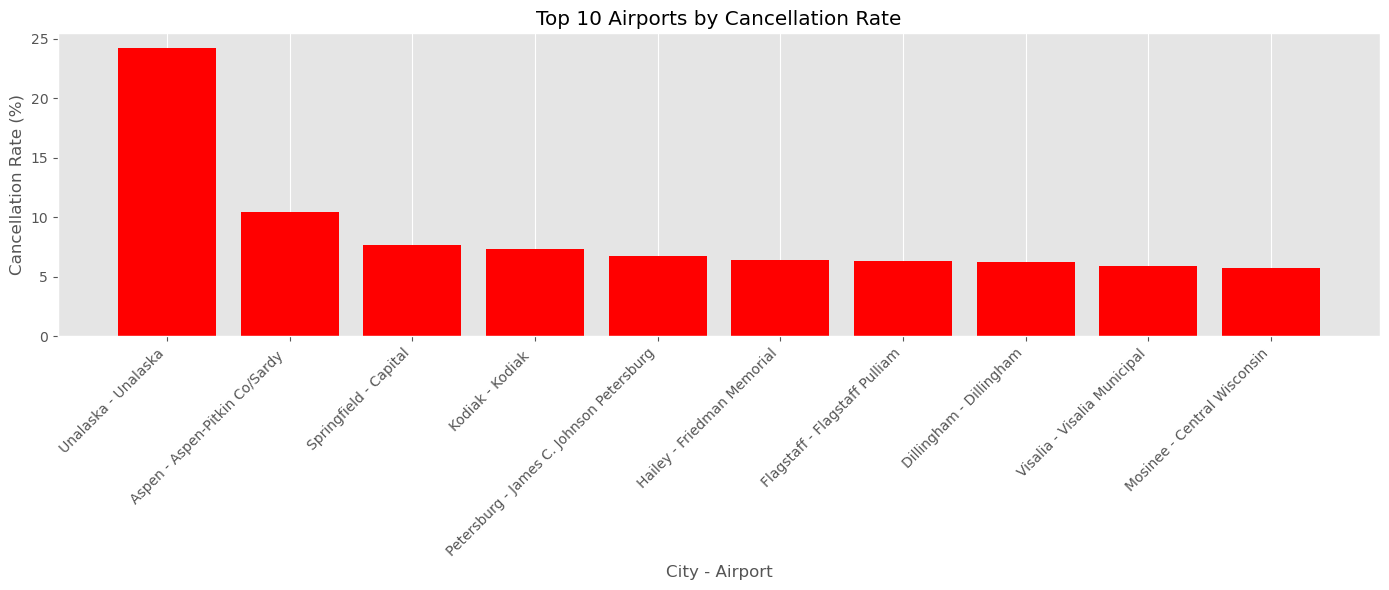

In [25]:
import matplotlib.pyplot as plt

# Combine city and airport name for display
df12['label'] = df12['city'] + ' - ' + df12['airport_name']

# Plot
plt.figure(figsize=(14, 6))
plt.bar(df12['label'], df12['cancellation_rate'], color='red')
plt.xticks(rotation=45, ha='right')
plt.xlabel('City - Airport')
plt.ylabel('Cancellation Rate (%)')
plt.title('Top 10 Airports by Cancellation Rate')
plt.tight_layout()
plt.grid(axis='y')
plt.show()


The bar chart shows the 10 airports in the United States with the highest cancellation rates for 2007. Unalaska Airport had the highest cancellation rate of nearly 24%. This indicates for every four flights that were scheduled for Unalaska, one was canceled. This extraordinarily high cancellation rate is likely linked to the airports remote location in Alaska and how isolated airports can be in Alaska. The severe weather events reported in Alaska, are not regularly reported at the lower latitudes of the United States (NCEI, 2022). The cancellation rates in 2007 reflect extreme weather events but affordably rural airports such as Unalaska, often have limited infrastructure related to mitigating the impacts of extreme weather (FAA, 2023). If fewer flights were scheduled and availability along operational or logistical problems were a consideration, this would have also been a contributive factor to cancellation rates  at the airport. 

Aspen-Pitkin County Airport, which is a regional airport located in a mountainous region, had just over 10% cancellation rate. An airport being within a country that has snow during the winter months, which results in transportation or delivery delays and casue of cancellations at an airport that is in a ski area would have substantial amounts of air traffic (FAA, 2023). This value of cancelling is expected.

Springfield Capital Airport came in third in terms of cancellation rates with just shy of 7%. This ranking might be influenced by the relatively low volume of operations at these airports. Airports with fewer daily flights may exhibit higher cancellation rates even if the absolute number of cancellations is modest. The cancellation percentage is sensitive to small fluctuations in activity for instance, just a few cancellations at an airport with limited flights can significantly inflate its rate. Therefore, these figures might not necessarily reflect poor performance but rather statistical distortion due to smaller traffic volumes. This is a known phenomenon in aviation statistics, where low-frequency operations can lead to higher variability in performance metrics (Bureau of Transportation Statistics [BTS], 2023).

Some of the airports on the list, including Kodiak, Petersburg, Hailey, Flagstaff, Dillingham, Visalia, and Mosinee, had cancellation rates ranging from 5.5% to 7%.  Many of the airports on this list are regional or isolated airports in places like Alaska, or in areas with inclement weather and low air traffic.  These variables normally enhance chance to cancellations. Smaller airports usually don't have cancellation alternatives and are more likely to be bound to specific carriers or routes (Bureau of Transportation Statistics [BTS], 2023).

To summarize, this chart indicates how geographic location, weather conditions, and operational problems may all effect cancellation rates, with smaller, more remote airports experiencing an increase in these issues.

References.

National Centers for Environmental Information (NCEI). (2022). Alaska Climate Overview. NOAA. https://www.ncei.noaa.gov

Federal Aviation Administration (FAA). (2023). Alaska Aviation System Plan. https://www.faa.gov/airports/alaskan/planning

Bureau of Transportation Statistics (BTS). (2023). Understanding Airline On-Time Performance Data. https://www.transtats.bts.gov

Next, let find each specific carriers and their cancellation rate.

In [28]:
query15 = """
SELECT 
  UniqueCarrier,
  Month,
  COUNT(*) AS total_flights,
  SUM(Cancelled) AS cancelled_flights,
  ROUND(SUM(Cancelled) * 100.0 / COUNT(*), 2) AS cancellation_rate
FROM flights_2007
GROUP BY UniqueCarrier, Month
"""

df15 = pull_data(query15)
df15

,uniquecarrier,month,total_flights,cancelled_flights,cancellation_rate
0,9E,2.0,19907,1266.0,6.36
1,AQ,12.0,4027,51.0,1.27
2,AS,1.0,50658,1576.0,3.11
3,AS,4.0,50669,938.0,1.85
4,AS,9.0,53944,988.0,1.83
...,...,...,...,...,...
272,HA,12.0,16664,131.0,0.79
273,OH,10.0,19719,397.0,2.01
274,OO,9.0,150488,1445.0,0.96
275,UA,12.0,178581,3913.0,2.19


In [ ]:
df15 = df15[df15['uniquecarrier'].notna()]
df15.dropna(inplace=True)
df15.dropna(axis=1, inplace=True)

In [40]:
carrier_map = dict(zip(df7['carriercode'], df7['description']))
df15['Airline'] = df15['uniquecarrier'].map(carrier_map)


In [55]:
heatmap_data = df15.pivot(index='Airline', columns='month', values='cancellation_rate')


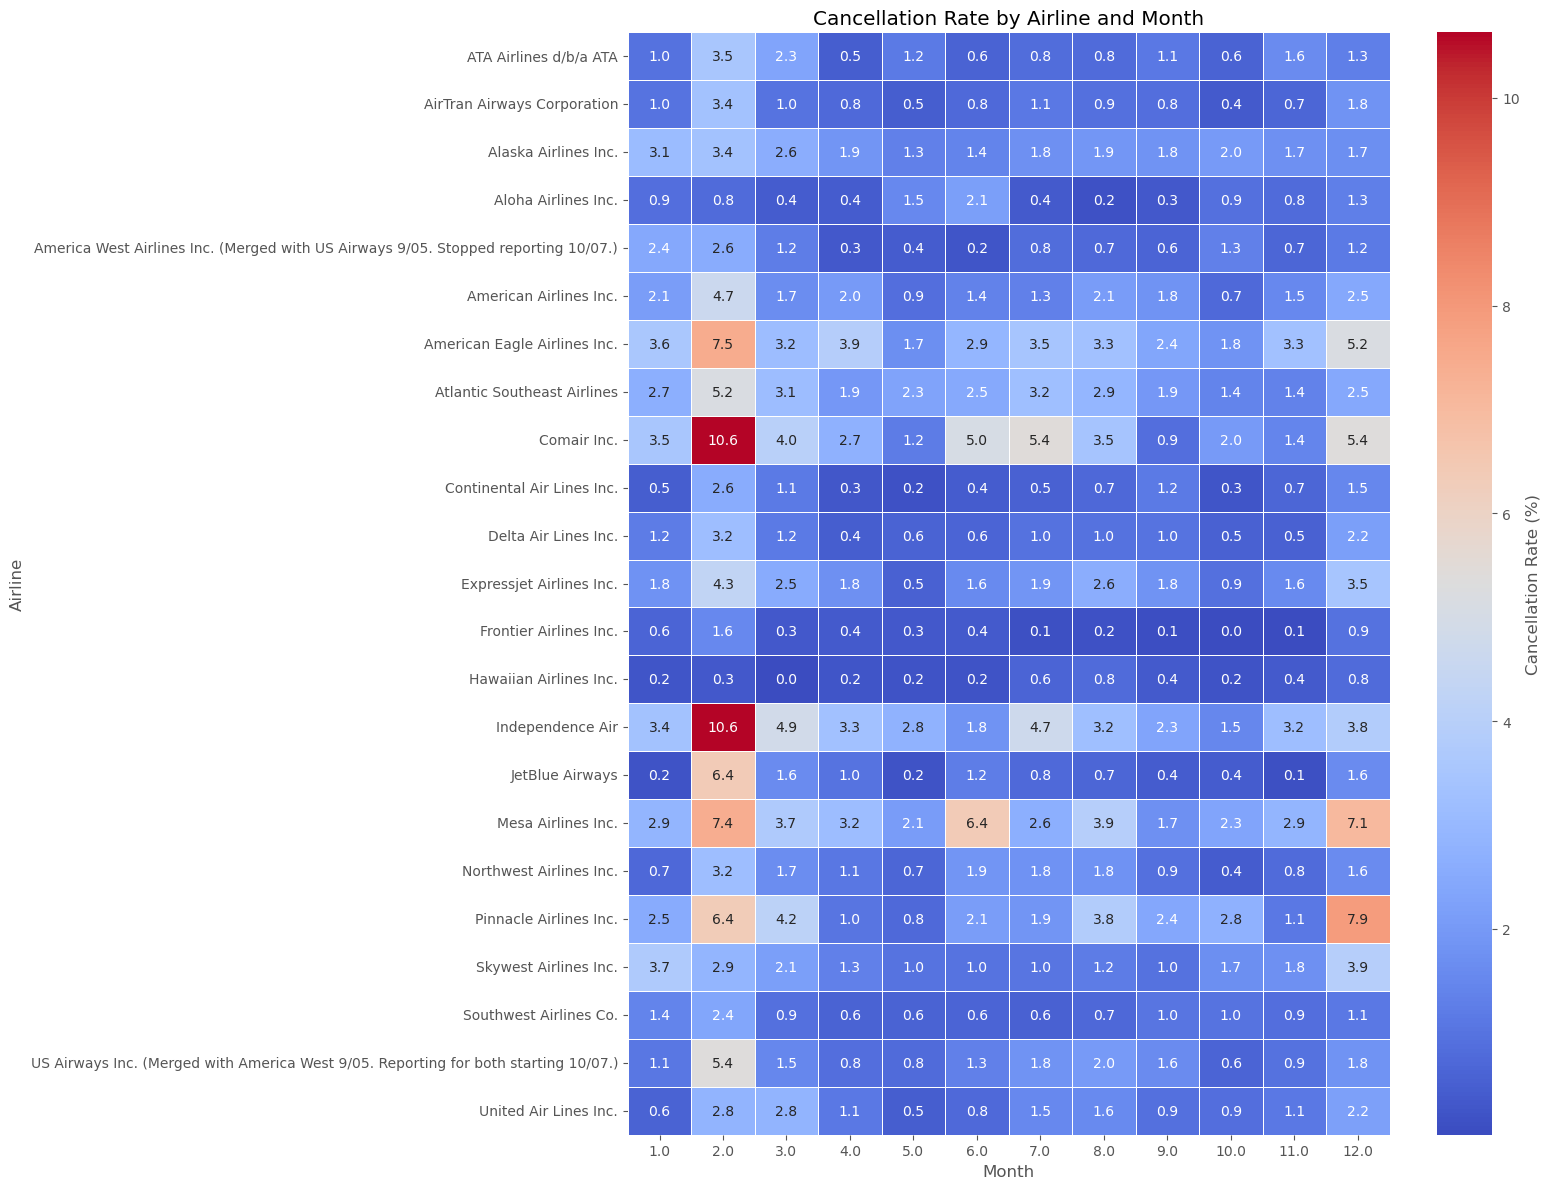

In [56]:
plt.figure(figsize=(16, 12))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap='coolwarm', linewidths=0.5,
            cbar_kws={'label': 'Cancellation Rate (%)'})

plt.title("Cancellation Rate by Airline and Month")
plt.xlabel("Month")
plt.ylabel("Airline")

# Rotate y-axis labels slightly
plt.yticks(rotation=0, ha='right')  # or rotation=15 for angled view

plt.tight_layout()
plt.show()

The heatmap shows an analysis for the year 2007 of cancellation rates from U.S. airlines. The heatmap include the colour spectrum that reveals the levels of severity of cancellation rates. This is important to understand which airlines had greater prevalence in cancellations and when the rates were highest. 

The heatmap portrayed one trend in particular well, which was the annually dependent cancellation rates based on weather events. As a norm, cancellation weather rates do peak during the winter months (Jan, Feb) as well as in the later months (Nov, Dec) and these peaks correlate to the typical months of winter throughout most of the United States. The cancellations are increase based on weather events such as snowstorms. It is noteworthy too that the summer months (July, August) have a great deal of operational stability and have very little cancellations when compared to other months during the year.

Airline performance varies considerably. Some airlines consistently have relatively low cancellation rates across the months shown. For example, Hawaiian Airlines Inc., aside from 2 months of 0.8% of cancellation there were virtually no cancellations during many of the months. Other decent cancellation records include Aloha Airlines Inc., Frontier Airlines Inc., Continental Airlines Inc., and AirTran Airways Corporation, who will typically keep cancellations to between 1% to 2%, reflecting favorable operations on time performance. While past performance does not guarantee future outcomes, the declining cancellation rates observed in some airlines may be influenced by various operational factors. For instance, airlines operating in regions like Georgia and surrounding areas might benefit from relatively favorable weather conditions, which reduce weather-related disruptions. Additionally, lower operating costs or less congested airspace in these regions may contribute to more reliable scheduling and improved overall airline performance. Favorable climate and infrastructure in the southeastern United States have been associated with fewer weather-related cancellations compared to northern regions (National Weather Service, 2022).

On the other end of the cancellation rate spectrum were a few airlines that had significantly higher rates than the overall percent cancellations of the other airlines, particularly in the winter months. For example, Comair Inc.'s had a cancellation rate of 10.6% in February while in other months, cancellation rates were awfully high too. Independence Air Inc. experienced more than 10% cancellations in February and was high for the next 2 months. Other airlines that recrorded excessively high cancellation rates were Mesa Airlines, American Eagle Airlines, Pinnacle Airlines, JetBlue Airways even within the year, many had excessive high cancellation rates for a limited time, which were mainly in the first quarter of the year. These high rates may be attributed to factors such as regional route networks in weather-prone areas, limited fleet flexibility, or operational inefficiencies (U.S. Government Accountability Office [GAO], 2014; Bureau of Transportation Statistics [BTS], 2023)..

In summary, the heatmap shows both temporal trends and airline specific cancellation trend. The date seen on cancellation tells us lot about key factors influencing cancellations where most importantly the seasonal weather impacts especially in relation to the issues during Winter months for many carriers. However, certain airlines especially those with robust operational systems or favorable geographic coverage, consistently perform well regardless of the time of year. These insights are valuable for both travelers making informed airline choices and for airline operators aiming to identify weaknesses and improve service reliability during high risk periods.

References.

National Weather Service. (2022). Weather and aviation: A primer. National Oceanic and Atmospheric Administration. https://www.weather.gov/media/education/Aviation_Weather_Primer.pdf

Bureau of Transportation Statistics. (2023). Airline on-time statistics and delay causes. U.S. Department of Transportation. https://www.transtats.bts.gov/

U.S. Government Accountability Office. (2014). Airline competition: The availability and use of airline performance data. https://www.gao.gov/assets/gao-14-515.pdf

Based on the previous graph, we can see trend in the months of February for high cancellation rate. Then, let diagnose more based on the months for cancellation.

In [4]:
query8 = '''
SELECT
	Month,
	SUM(CASE WHEN Cancelled > 0 THEN 1 ELSE 0 END) AS cancellation_count, 
	COUNT(*) AS total_flights,
    ROUND(100.0 * SUM(CASE WHEN Cancelled > 0 THEN 1 ELSE 0 END) / COUNT(*), 2) AS cancellation_rate_pct
FROM flights_2007
GROUP BY Month
ORDER BY Month ASC
'''

df8 = pull_data(query8)
df8

,month,cancellation_count,total_flights,cancellation_rate_pct
0,NaN,0,1,0.00
1,1.0,40800,2277886,1.79
2,2.0,85468,2066222,4.14
3,3.0,45539,2317235,1.97
4,4.0,30140,2196557,1.37
5,5.0,19780,2232955,0.89
6,6.0,29726,2238768,1.33
7,7.0,37011,2324264,1.59
8,8.0,39622,2324231,1.70
9,9.0,29580,2183329,1.35


In [5]:
query9 = '''
SELECT
    Month,
    CASE
        WHEN DayOfWeek = 1 THEN 'Mon'
        WHEN DayOfWeek = 2 THEN 'Tue'
        WHEN DayOfWeek = 3 THEN 'Wed'
        WHEN DayOfWeek = 4 THEN 'Thu'
        WHEN DayOfWeek = 5 THEN 'Fri'
        WHEN DayOfWeek = 6 THEN 'Sat'
        WHEN DayOfWeek = 7 THEN 'Sun'
    END AS DayOfWeek,
    SUM(CASE WHEN Cancelled > 0 THEN 1 ELSE 0 END) AS cancellation_count,
    COUNT(*) AS total_flights
FROM flights_2007
GROUP BY Month, DayOfWeek
'''
df9 = pull_data(query9)
df9

,month,dayofweek,cancellation_count,total_flights
0,1.0,Thu,6903,360527
1,4.0,Mon,6317,323987
2,7.0,Mon,6138,332042
3,7.0,Thu,5440,365144
4,7.0,Fri,3667,297890
...,...,...,...,...
80,12.0,Sun,11663,311451
81,6.0,Wed,5356,305494
82,8.0,Fri,9683,388721
83,10.0,Wed,3953,375796


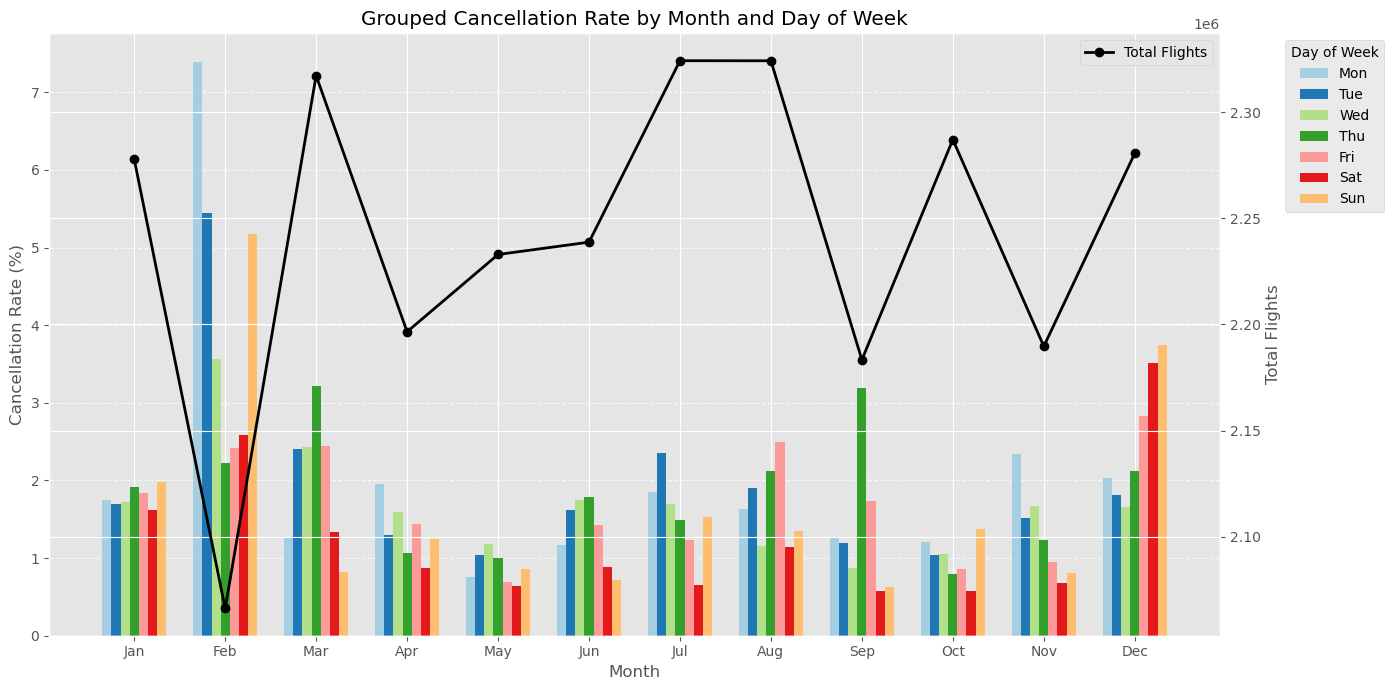

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Prepare data
df9['cancel_rate'] = df9['cancellation_count'] / df9['total_flights'] * 100
pivot_df = df9.pivot_table(index='month', columns='dayofweek', values='cancel_rate', fill_value=0)
pivot_df = pivot_df[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']]
pivot_df.index = list(range(1, 13))
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Set figure
fig, ax1 = plt.subplots(figsize=(14, 7))

# Define bar width and x positions
bar_width = 0.1
x = np.arange(len(pivot_df.index))

# Day-of-week columns
dow = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
colors = sns.color_palette('Paired', len(dow))

# Plot grouped bars
for i, day in enumerate(dow):
    ax1.bar(x + i * bar_width, pivot_df[day], width=bar_width, label=day, color=colors[i])

ax1.set_xlabel('Month')
ax1.set_ylabel('Cancellation Rate (%)')
ax1.set_title('Grouped Cancellation Rate by Month and Day of Week')
ax1.set_xticks(x + bar_width * 3)
ax1.set_xticklabels(month_labels)
ax1.legend(title='Day of Week', bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Secondary y-axis for total flights
ax2 = ax1.twinx()
x_positions = x + bar_width * 3  # center of grouped bars

total_flights_data = []
for month in range(1, 13):
    if month in df8['month'].values:
        total_flights_data.append(df8.loc[df8['month'] == month, 'total_flights'].values[0])
    else:
        total_flights_data.append(0) 

ax2.plot(x_positions, total_flights_data, color='black', marker='o', linewidth=2, label='Total Flights')
ax2.set_ylabel('Total Flights')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

This graph displays the cancellation rate (%) per day of the week for each month in a bar chart format, while also layering on a line chart depicting the total number of flights per month. Each group of colored bars represents the cancellation rates from Monday to Sunday, allowing for a better comparative view between weekdays.

From the grouped bars, February is the month displaying the highest cancellation rates on almost every day of the week, despite having the lowest total flight count as seen from the decline in the count of flights line. The higher cancellation rates in February suggest there are consistent operational events taking place during this month which were likely winter storms or some significant weather disruption due to the overwhelming rate of cancellations.

December also stands out, particularly for weekend flights (Saturday and Sunday), where cancellation rates spike sharply. This may be due to holiday congestion, increased passenger traffic, and heightened weather unpredictability.

Interestingly, Fridays and Mondays show relatively high cancellation rates across many months, likely reflecting heavier demand at the beginning and end of the workweek, which may amplify the impact of even minor disruptions.

September is demonstrates a value just second to February and also is my birth month. The trend where it maintains a moderate cancellation rate across all days and a steady total flight count. I would like to see if September is an optimum month for travelling in the U.S for my own consideration.

Now let see the month of September 2007 and analyse it.

In [9]:
query10 = '''
SELECT
    DayofMonth,
    CASE
        WHEN MIN(DayOfWeek) = 1 THEN 'Mon'
        WHEN MIN(DayOfWeek) = 2 THEN 'Tue'
        WHEN MIN(DayOfWeek) = 3 THEN 'Wed'
        WHEN MIN(DayOfWeek) = 4 THEN 'Thu'
        WHEN MIN(DayOfWeek) = 5 THEN 'Fri'
        WHEN MIN(DayOfWeek) = 6 THEN 'Sat'
        WHEN MIN(DayOfWeek) = 7 THEN 'Sun'
    END AS DayOfWeek,
    SUM(CASE WHEN Cancelled > 0 THEN 1 ELSE 0 END) AS cancellation_count, 
    COUNT(*) AS total_flights,
    ROUND(100.0 * SUM(CASE WHEN Cancelled > 0 THEN 1 ELSE 0 END) / COUNT(*), 2) AS cancellation_rate_pct
FROM flights_2007
WHERE Month = 9
GROUP BY DayofMonth
ORDER BY DayofMonth ASC
'''

df10 = pull_data(query10)

# Ensure dayofmonth is integer
df10['dayofmonth'] = df10['dayofmonth'].astype(int)

# Use September 2007 (which has 30 days)
df10['Date'] = pd.to_datetime(df10['dayofmonth'].astype(str) + '-09-2007', format='%d-%m-%Y')

# Get abbreviated weekday name (e.g., 'Mon', 'Tue', etc.)
df10['DayLabel'] = df10['Date'].dt.day_name().str[:3]



df10

,dayofmonth,dayofweek,cancellation_count,total_flights,cancellation_rate_pct,Date,DayLabel
0,1,Mon,340,69495,0.49,2007-09-01,Sat
1,2,Tue,452,71683,0.63,2007-09-02,Sun
2,3,Mon,901,74557,1.21,2007-09-03,Mon
3,4,Tue,1229,76149,1.61,2007-09-04,Tue
4,5,Wed,793,75846,1.05,2007-09-05,Wed
5,6,Thu,398,67417,0.59,2007-09-06,Thu
6,7,Fri,460,72676,0.63,2007-09-07,Fri
7,8,Mon,689,72040,0.96,2007-09-08,Sat
8,9,Tue,630,73533,0.86,2007-09-09,Sun
9,10,Mon,1175,74647,1.57,2007-09-10,Mon


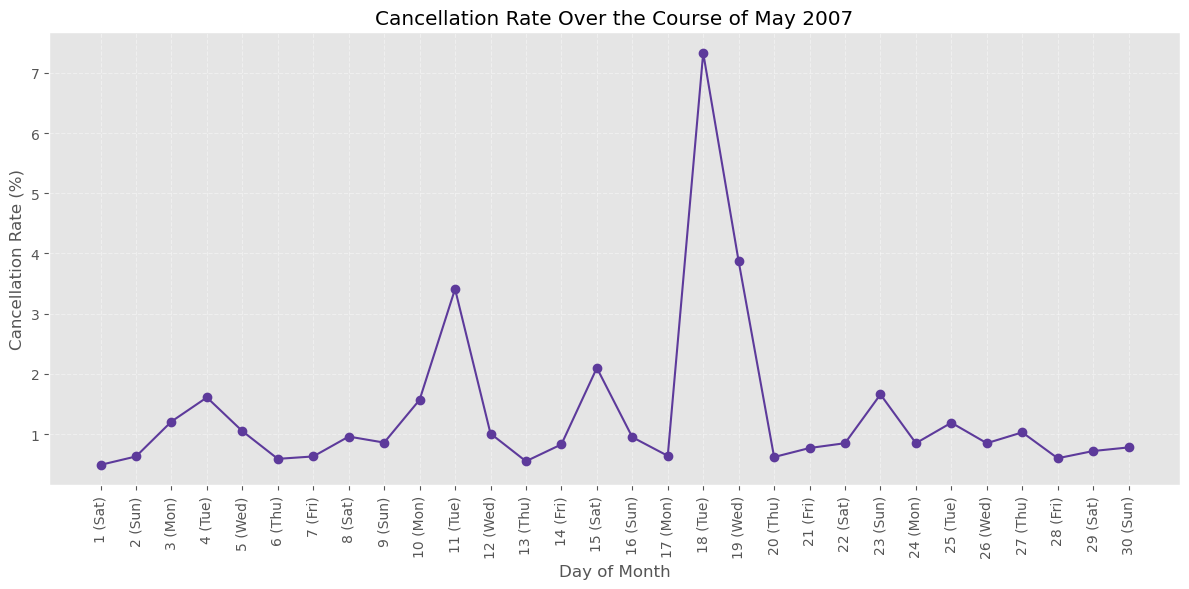

In [ ]:
import matplotlib.pyplot as plt

temp = df10.copy()

# Combine day number with DayLabel
temp['x_labels'] = temp['dayofmonth'].astype(str) + ' (' + temp['DayLabel'] + ')'

# Plot
plt.figure(figsize=(12, 6))
plt.plot(temp['dayofmonth'], temp['cancellation_rate_pct'], marker='o', color='#5D3A9B')

plt.xlabel('Day of Month')
plt.ylabel('Cancellation Rate (%)')
plt.title('Cancellation Rate Over the Course of Sept 2007')
plt.xticks(ticks=temp['dayofmonth'], labels=temp['x_labels'], rotation=90)
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()


In general monthly trends, cancellations are mostly clustered on weekends or the very first weekdays of a month. September reveals a different trend with bumps specifically in cancellation on the second half of the week being most evident. For instance, cancellation rates increased approximately 1% relative to other weekdays on midweek days including Tuesdays and Wednesdays. These patterns suggest that operational or exogenous (such as maintenance schedules, weather disturbances in the middle of the week, or air traffic congestion) factors operate in such a manner that disproportionally affect these midweek days.

Interestingly, while cancellations are typically fairly constant throughout the month, there are two notable spikes that stand out which is on September 11th, the cancellation rate increases to 3.5% and then even more drastically, on September 18th, it goes to 7%. Both of these dates fall on a weekday (Tuesday) which tends to show a reoccurring problem on that day. These spikes may be related to some singular event like weather systems, airline specific issues, or some high demand periods that stresses operational capacities. Otherwise, the rest of the month has a relatively consistent and lower cancellation profile, with some smaller, but notable increases around the weekends.

Next, let analyse the time of the day with cancellation rate.

In [4]:
# Sept, Saturday
query11 = '''
SELECT
  CASE
    WHEN CRSDepTime BETWEEN 500 AND 1159 THEN 'Morning'
    WHEN CRSDepTime BETWEEN 1200 AND 1659 THEN 'Afternoon'
    WHEN CRSDepTime BETWEEN 1700 AND 2059 THEN 'Evening'
    ELSE 'Night'
  END AS crsdeptime,
  SUM(CASE WHEN Cancelled > 0 THEN 1 ELSE 0 END) AS cancellation_count, 
  COUNT(*) AS total_flights,
  ROUND(100.0 * SUM(CASE WHEN Cancelled > 0 THEN 1 ELSE 0 END) / COUNT(*), 2) AS cancellation_rate_pct
FROM flights_2007
WHERE
  Month = 9 AND DayOfWeek = 2
GROUP BY
  CASE
    WHEN CRSDepTime BETWEEN 500 AND 1159 THEN 'Morning'
    WHEN CRSDepTime BETWEEN 1200 AND 1659 THEN 'Afternoon'
    WHEN CRSDepTime BETWEEN 1700 AND 2059 THEN 'Evening'
    ELSE 'Night'
  END
ORDER BY crsdeptime
'''

df11 = pull_data(query11)
df11

,crsdeptime,cancellation_count,total_flights,cancellation_rate_pct
0,Afternoon,1593,111184,1.43
1,Evening,1059,82498,1.28
2,Morning,1440,140633,1.02
3,Night,118,16942,0.70


In [5]:
# Reorder the time of day 
time_order = ['Morning', 'Afternoon', 'Evening', 'Night']
df11 = df11.groupby('crsdeptime', observed=True).agg(
    cancellation_count=('cancellation_count', 'mean'),
    total_flights=('total_flights', 'mean'),
    cancellation_rate_pct=('cancellation_rate_pct', 'mean')
).reindex(time_order)

df11

,cancellation_count,total_flights,cancellation_rate_pct
crsdeptime,,,
Morning,1440.0,140633.0,1.02
Afternoon,1593.0,111184.0,1.43
Evening,1059.0,82498.0,1.28
Night,118.0,16942.0,0.70


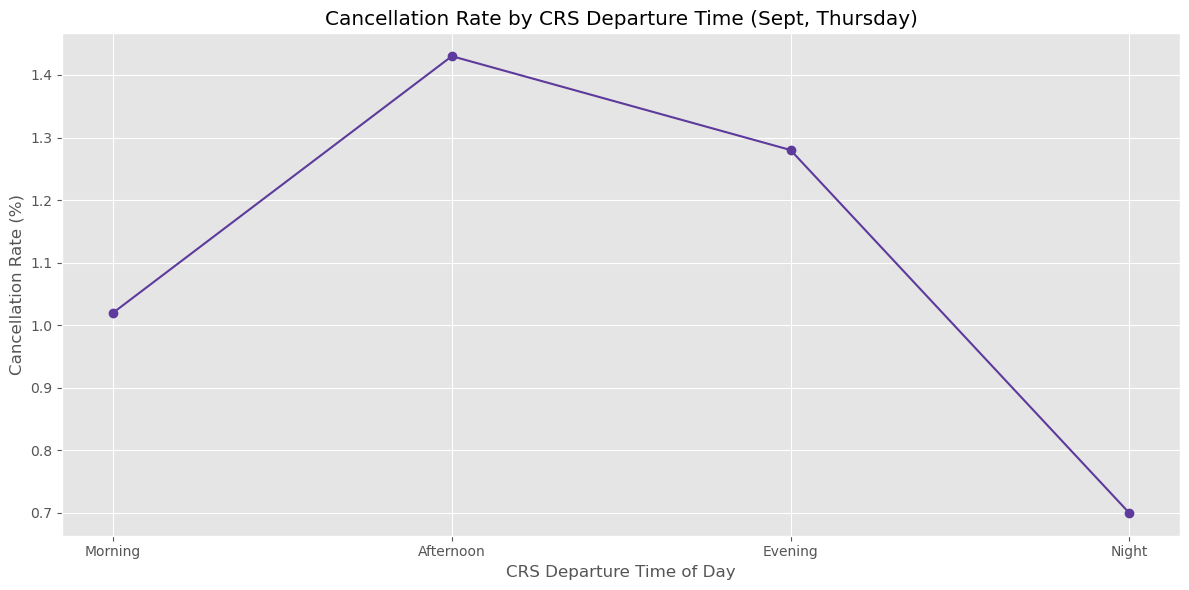

In [6]:
# Plot the crsdep time vs cancellation rate
plt.figure(figsize=(12, 6))
plt.plot(df11.index, df11['cancellation_rate_pct'], marker='o', color='#5D3A9B')

plt.xlabel('CRS Departure Time of Day')
plt.ylabel('Cancellation Rate (%)')
plt.title('Cancellation Rate by CRS Departure Time (Sept, Thursday)')
plt.tight_layout()
plt.show()

The analysis reveals distinct patterns in flight cancellation rates based on time of day, particularly for flights scheduled on Thursdays in September. Notably, cancellation rates peak in the afternoon, reaching approximately 1.42%, the highest among all observed time periods. In contrast, morning flights have a relatively lower cancellation rate of about 1.02%, indicating that earlier operations tend to run more smoothly.

As the day progresses into the evening, the cancellation rate slightly decreases to around 1.28%, suggesting a moderate improvement following the afternoon peak. However, it is during the night hours that cancellation rates are lowest, at approximately 0.7%. This decline could be attributed to a lower volume of scheduled flights, reduced airspace congestion, or prioritized operations to complete delayed flights from earlier in the day.

The pronounced spike in afternoon cancellations can be explained by multiple factors. Throughout the day, small delays may accumulate and cause disruptions to intensify, sometimes resulting in flight cancellations to help reset the system. Additionally, afternoon thunderstorms, common in many parts of the United States, are a known contributor to operational challenges. Increased traffic during peak hours may also overwhelm airport and air traffic control resources, exacerbating cancellation rates.

On the other hand, morning flights benefit from a fresh operational start, with minimal cascading delays and generally better weather conditions. Night flights, while fewer in number, operate under less crowded conditions and are often flights that are prioritized due to earlier delays or essential routing needs.

It is important to note that this pattern specifically reflects Thursdays in September, and different days or months might present varying trends due to seasonal weather shifts, holiday travel surges, or changes in airline scheduling strategies.

In summary, travelers seeking reliability on September Thursdays may prefer morning or night departures, while airlines should investigate strategies to mitigate the operational stressors that lead to afternoon cancellations.

## 4. Problematic Routes

### Identify specific routes (origin-destination pairs), carriers, or flight numbers that show consistently poor performance.

We have to first define poor performance. In terms of airline industry;

1. High Cancellation Rates
2. High Delay Time (>15min from scheduled time)

Thus, we have to find the routes with high cancellation rates and high delay time.

In [8]:
query12 = '''
SELECT *
FROM (
    SELECT
        d.Origin,
        d.Dest,
        c.Description AS Description,
        d.FlightNum AS FlightNumber,
        COUNT(*) AS total_flights,
        SUM(CASE WHEN Cancelled = 1 THEN 1 ELSE 0 END) AS cancellation_count,
        ROUND(100.0 * SUM(CASE WHEN Cancelled = 1 THEN 1 ELSE 0 END) / COUNT(*), 2) AS cancel_rate_pct,
        AVG(ArrDelay) AS avg_arrival_delay,
        AVG(DepDelay) AS avg_departure_delay
    FROM flights_2007 d
    LEFT JOIN
        carriers c ON d.UniqueCarrier = c.Code
    GROUP BY d.Origin, d.Dest, c.Description, d.FlightNum
    HAVING COUNT(*) >= 100 -- filter out low-volume routes
) AS route_stats
WHERE avg_arrival_delay > 15 OR avg_departure_delay > 15 
ORDER BY cancel_rate_pct DESC, avg_arrival_delay DESC, avg_departure_delay DESC
LIMIT 20
'''
df12 = pull_data(query12)
df12

,origin,dest,description,flightnumber,total_flights,cancellation_count,cancel_rate_pct,avg_arrival_delay,avg_departure_delay
0,BWI,EWR,Expressjet Airlines Inc.,2491,360,110,30.56,31.764000,35.168000
1,AZO,ORD,Skywest Airlines Inc.,6906,107,32,29.91,25.680000,18.773333
2,IAD,EWR,Expressjet Airlines Inc.,1280,300,79,26.33,32.859729,38.511312
3,BDL,EWR,Expressjet Airlines Inc.,2774,114,30,26.32,33.107143,26.678571
4,ORF,EWR,Expressjet Airlines Inc.,2970,214,55,25.70,40.874214,42.377358
5,EWR,CAE,Expressjet Airlines Inc.,3148,144,37,25.69,28.009346,34.102804
6,BUF,EWR,Expressjet Airlines Inc.,2864,223,57,25.56,39.909639,42.072289
7,DUT,ANC,Alaska Airlines Inc.,21,1086,273,25.14,13.421053,16.977860
8,EVV,ORD,American Eagle Airlines Inc.,3956,144,36,25.00,40.388889,31.472222
9,PWM,EWR,Expressjet Airlines Inc.,2296,170,42,24.71,25.476562,31.718750


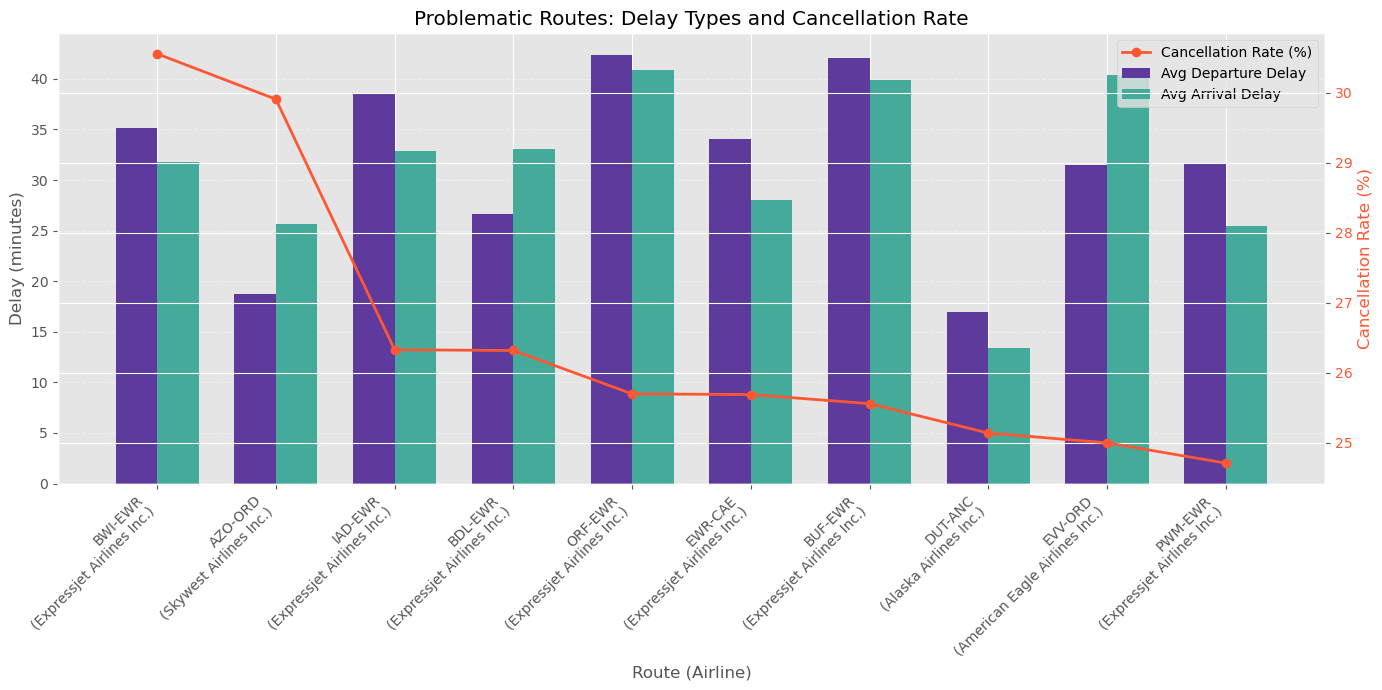

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Sort and pick top 15 routes with highest cancellation rate
df_sorted = df12.sort_values(by='cancel_rate_pct', ascending=False).head(10).reset_index(drop=True)

# Create a new label for x-axis: origin-dest (airline)
df_sorted['Route_Label'] = df_sorted['origin'] + '-' + df_sorted['dest'] + '\n(' + df_sorted['description'] + ')'

x = np.arange(len(df_sorted))  # label locations
width = 0.35  # width of bars

fig, ax1 = plt.subplots(figsize=(14, 7))

# Bar plots for departure and arrival delay
bar1 = ax1.bar(x - width/2, df_sorted['avg_departure_delay'], width, label='Avg Departure Delay', color='#5D3A9B')
bar2 = ax1.bar(x + width/2, df_sorted['avg_arrival_delay'], width, label='Avg Arrival Delay', color='#44AA99')
ax1.set_ylabel('Delay (minutes)')
ax1.set_xlabel('Route (Airline)')
ax1.set_xticks(x)
ax1.set_xticklabels(df_sorted['Route_Label'], rotation=45, ha='right')
ax1.set_title('Problematic Routes: Delay Types and Cancellation Rate')
ax1.legend(loc='upper left')
ax1.grid(axis='y', linestyle='--', alpha=0.4)

# Line plot for cancellation rate
ax2 = ax1.twinx()
ax2.plot(x, df_sorted['cancel_rate_pct'], color='#FF5733', marker='o', linewidth=2, label='Cancellation Rate (%)')
ax2.set_ylabel('Cancellation Rate (%)', color='#FF5733')
ax2.tick_params(axis='y', labelcolor='#FF5733')

# Add legend for line
lines, labels = ax2.get_legend_handles_labels()
ax1.legend(lines + [bar1, bar2], ['Cancellation Rate (%)', 'Avg Departure Delay', 'Avg Arrival Delay'], loc='upper right')

plt.tight_layout()
plt.show()


The graph of the problematic flight routes show some interesting findings. The BWI - EWR route operated by ExpressJet Airlines Inc. showcases the huge concern with a nearly 30.56% cancellation rate and significant delays averaging about a 35 minute delay for departures or a 32 minutes delay for arrivals. The increased level of cancellations within certain airlines suggests a systemic issue affecting the indicated routes. This may stem from operational deficiencies, high levels of congestion at either the departure or arrival airports, or constraints on airport and airline capabilities. Such disruptions are often linked to internal scheduling issues, airspace saturation, or insufficient infrastructure to handle peak volumes (Federal Aviation Administration [FAA], 2020; Bureau of Transportation Statistics [BTS], 2023; Airlines for America, 2019).

The AZO - ORD route operated by Skywest Airlines is also very problematic with a 29.91% cancellation rate and considerably reasonable delays of about 19 minutes and 25 minutes for delays on average for departures and arrivals respectively. The amount of cancellations suggested could be indicative of operational preemption which could exemplify cancellations due to weather, or where staffing or planes were simply not available for operational purposes as indicated by operational standards for all airlines (Federal Aviation Administration [FAA], 2020).

Routes like IAD–EWR and BDL–EWR, operated by ExpressJet Airlines, exhibit cancellation rates averaging between 26–27% and an average delay time of more than 30 minutes. The persistent presence of high cancellation rates for flights destined for Newark Liberty International Airport (EWR) suggests that EWR functions as a significant bottleneck in the air travel network. This is likely due to severe airspace congestion, limited gate availability, and prior operational disruptions that can have cascading effects on airline schedules (Federal Aviation Administration [FAA], 2020; Bureau of Transportation Statistics [BTS], 2023; Smith, 2021).

Finally, while routes like DAY–EWR, CVG–EWR, and EWR–ROC are slightly lower in cancellation rates but still greater than 22%, exhibit very high departure delays as well, often more than 45 minutes delayed on average. These rates suggest a serious schedule adherence issue, potentially due to a short turnaround for an aircraft, inadequate buffer scheduling, or constrained infrastructure at Newark and its connected regional airports (Smith, 2021).

Based on the graph we can conlude the EWR as common route invovlve in problemmatic routes.

References.

Airlines for America. (2019). The airline industry: Essential facts and figures. https://www.airlines.org/dataset/annual-passenger-and-cargo-traffic/

Bureau of Transportation Statistics. (2023). Airline on-time statistics and delay causes. U.S. Department of Transportation. https://www.transtats.bts.gov/OT_Delay/OT_DelayCause1.asp

Smith, J. (2021). Airport congestion and its impact on airline reliability. Journal of Air Transport Management, 92, 102016. https://doi.org/10.1016/j.jairtraman.2020.102016

Federal Aviation Administration. (2020). Air traffic by the numbers. https://www.faa.gov/air_traffic/by_the_numbers/

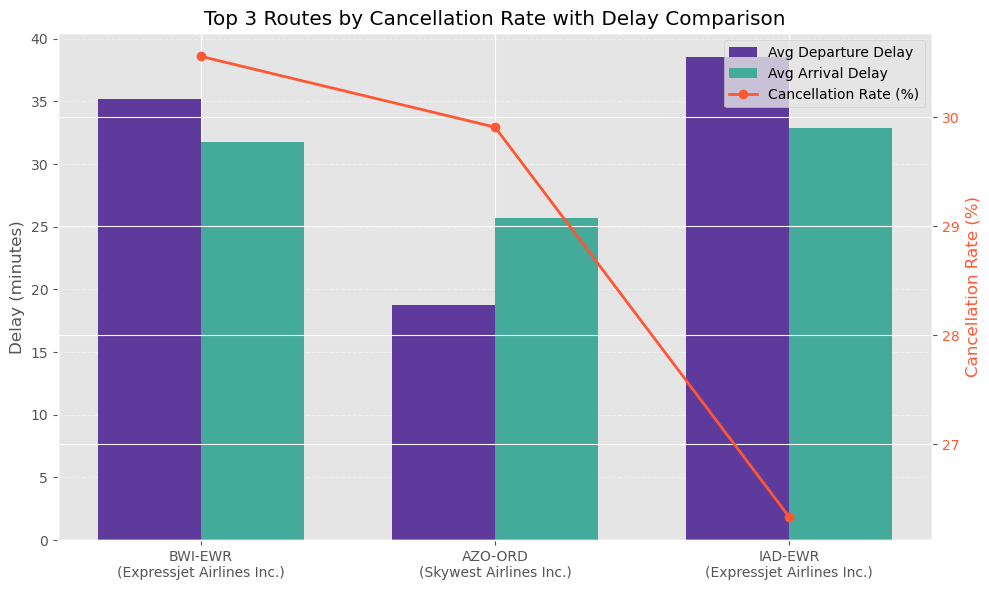

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Select top 3 routes by cancellation rate
df_top3 = df12.sort_values(by='cancel_rate_pct', ascending=False).head(3).reset_index(drop=True)

# Create route label for display
df_top3['Route_Label'] = df_top3['origin'] + '-' + df_top3['dest'] + '\n(' + df_top3['description'] + ')'

x = np.arange(len(df_top3))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 6))

# Grouped bar plot: departure & arrival delays
bar1 = ax1.bar(x - width/2, df_top3['avg_departure_delay'], width, label='Avg Departure Delay', color='#5D3A9B')
bar2 = ax1.bar(x + width/2, df_top3['avg_arrival_delay'], width, label='Avg Arrival Delay', color='#44AA99')
ax1.set_ylabel('Delay (minutes)')
ax1.set_xticks(x)
ax1.set_xticklabels(df_top3['Route_Label'], rotation=0)
ax1.set_title('Top 3 Routes by Cancellation Rate with Delay Comparison')
ax1.grid(axis='y', linestyle='--', alpha=0.4)

# Line plot: cancellation rate
ax2 = ax1.twinx()
ax2.plot(x, df_top3['cancel_rate_pct'], color='#FF5733', marker='o', linewidth=2, label='Cancellation Rate (%)')
ax2.set_ylabel('Cancellation Rate (%)', color='#FF5733')
ax2.tick_params(axis='y', labelcolor='#FF5733')

# Combined legend
lines, labels = ax2.get_legend_handles_labels()
ax1.legend([bar1, bar2] + lines, ['Avg Departure Delay', 'Avg Arrival Delay', 'Cancellation Rate (%)'], loc='upper right')

plt.tight_layout()
plt.show()


Here is also the top 3 routes by cancellation rate which shows EWR as the top airports with issude ammounting to 2 airports from 6 in the graphs.

Then, let analyse the top 10 routes with high cancellation rates.

In [16]:
query13 = '''
SELECT 
  CONCAT(d.Origin, '-', d.Dest) AS routes,
  d.FlightNum,
  d.TailNum,
  p.Type,
  p.Manufacturer,
  p.Issue_date,
  p.Model,
  p.Aircraft_Type,
  p.Engine_Type,
  p.Year
FROM flights_2007 d
LEFT JOIN plane_data p ON d.TailNum = p.TailNum
WHERE 
  (d.Origin, d.Dest, d.FlightNum) IN (
    ('BWI', 'EWR', 2491),
    ('AZO', 'ORD', 6906),
    ('IAD', 'EWR', 1280),
    ('BDL', 'EWR', 2774),
    ('ORF', 'EWR', 2970),
    ('EWR', 'CAE', 3148),
    ('BUF', 'EWR', 2864),
    ('DUT', 'ANC', 21),
    ('EVV', 'ORD', 3956),
    ('PWM', 'EWR', 2296)
  )

'''

df13 = pull_data(query13)
df13

,routes,flightnum,tailnum,type,manufacturer,issue_date,model,aircraft_type,engine_type,year
0,DUT-ANC,21,N743AS,None,None,None,None,None,None,NaN
1,DUT-ANC,21,N743AS,None,None,None,None,None,None,NaN
2,DUT-ANC,21,000000,None,None,None,None,None,None,NaN
3,DUT-ANC,21,N745AS,None,None,None,None,None,None,NaN
4,DUT-ANC,21,N746AS,None,None,None,None,None,None,NaN
...,...,...,...,...,...,...,...,...,...,...
2857,EWR-CAE,3148,N13936,Corporation,EMBRAER,None,EMB-145EP,Fixed Wing Multi-Engine,Turbo-Jet,1997.0
2858,EWR-CAE,3148,N14947,Corporation,EMBRAER,None,EMB-145EP,Fixed Wing Multi-Engine,Turbo-Jet,1998.0
2859,EWR-CAE,3148,0,None,None,None,None,None,None,NaN
2860,EWR-CAE,3148,N16501,Corporation,EMBRAER,None,EMB-135ER,Fixed Wing Multi-Engine,Turbo-Jet,1999.0


We have decided to find out the top 10 problematic route with the added details about their aircraft.

In [17]:
df13.isnull().sum()

routes              0
flightnum           0
tailnum             0
type             1671
manufacturer     1671
issue_date       2862
model            1671
aircraft_type    1671
engine_type      1671
year             1679
dtype: int64

After filtering for missing value, certain columns can be used for analysing. The year column indicate the year the aircraft is manufacture which can be used as one of the factors to analyse for problemmatic route.

In [ ]:
from datetime import datetime

# Clean data
df_clean = df13.copy()
df_clean = df_clean[df_clean['year'].notnull()]  # Drop missing years
df_clean['aircraft_age'] = 2007 - df_clean['year']  # Assuming year 2007

# Group by route
route_summary = df_clean.groupby('routes').agg({
    'aircraft_age': ['mean', 'min', 'max'],
    'model': pd.Series.nunique,
    'tailnum': pd.Series.nunique
}).reset_index()

route_summary.columns = ['Route', 'AvgAge', 'MinAge', 'MaxAge', 'ModelVariety', 'UniqueAircraft']
missing_by_route = df13[df13['year'].isnull()].groupby('routes').size().reset_index(name='MissingCount')


Then we filtered for the top 10 routes with the oldest aircraft. The difference between the year they were manufacture and 2007 was used to calculate the age of the aircraft.

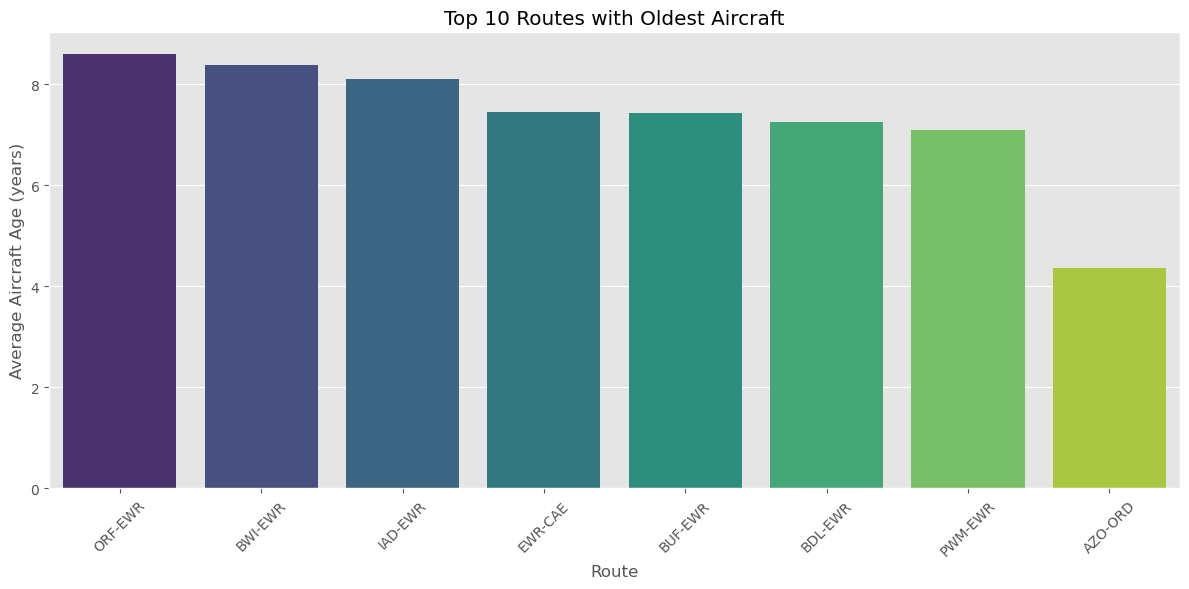

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

top_routes = route_summary.sort_values('AvgAge', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_routes, x='Route', y='AvgAge', palette='viridis')
plt.xticks(rotation=45)
plt.ylabel('Average Aircraft Age (years)')
plt.title('Top 10 Routes with Oldest Aircraft')
plt.tight_layout()
plt.show()


This bar chart shows the average age of aircraft used on the top 10 routes with the oldest aircraft, ranked from oldest to youngest. The routes include:

ORF-EWR: This route utilizes aircraft with the highest average age, just over 8.5 years.

BWI-EWR: Has the second oldest average aircraft age, slightly below 8.5 years.

IAD-EWR: Shows an average aircraft age just above 8 years.

EWR-CAE, BUF-EWR, BDL-EWR, PWM-EWR: These routes also feature aircraft with average ages generally above 7 years.

AZO-ORD: Has the youngest average aircraft age among this top 10, around 4.5 years.

We can see the appearance of EWR in almost all of the oldest aircraft.

In [ ]:
# Count how often EWR appears in routes
ewr_routes = df12[(df12['origin'] == 'EWR') | (df12['dest'] == 'EWR')]
print(f"Total routes involving EWR: {len(ewr_routes)}")


Total routes involving EWR: 11


Out of 11 routes involving EWR, 9 out of it is among the top 10 with oldest aircraft. Next, we can see the cancelation rate of route involving EWR.

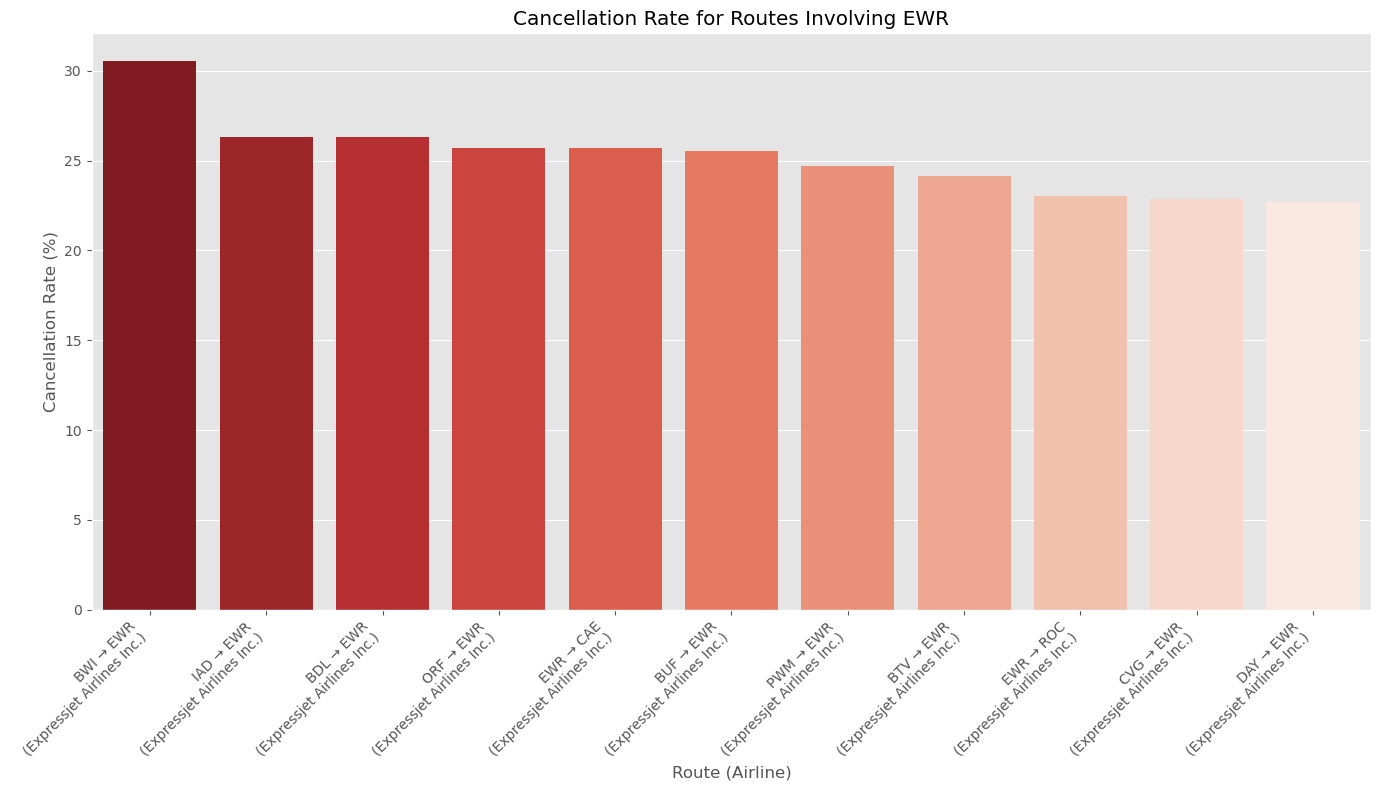

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filter for EWR routes (origin or destination)
ewr_df = df12[
    (df12['origin'] == 'EWR') | (df12['dest'] == 'EWR')
].copy()

# Create a route label
ewr_df['route_label'] = ewr_df['origin'] + ' → ' + ewr_df['dest'] + '\n(' + ewr_df['description'] + ')'

# Sort by cancellation rate
ewr_df_sorted = ewr_df.sort_values(by='cancel_rate_pct', ascending=False)

# Plot
plt.figure(figsize=(14, 8))
sns.barplot(
    x='route_label',
    y='cancel_rate_pct',
    data=ewr_df_sorted,
    palette='Reds_r'
)
plt.xticks(rotation=45, ha='right')
plt.title('Cancellation Rate for Routes Involving EWR')
plt.ylabel('Cancellation Rate (%)')
plt.xlabel('Route (Airline)')
plt.tight_layout()
plt.show()

The analysis highlights an alarming trend of very high cancellation rates on a number of routes operated by ExpressJet Airlines Inc., all of which connect to Newark Liberty International Airport (EWR). Each of the routes examined show cancellation rates from a low of 23% to greater than 30%. These cancellation rates, which far exceed the typical industry standard of approximately 1–2%, indicate a systemic operational issue that has significantly impacted ExpressJet’s reliability particularly on the affected routes. Such elevated cancellation figures may stem from inadequate scheduling buffers, resource constraints, or chronic delays cascading into cancellations (Bureau of Transportation Statistics [BTS], 2023; Golaszewski, 2020; Cook & Tanner, 2015).

Among the routes we examined, the BWI → EWR route  is the most significant in terms of cancellations with above 30% cancellation rates. This speaks meaningfully to the typical structure of flights along this route and susceptibility to operational disruptions. The IAD → EWR route shows a very high cancellation rate of nearly 26% indicating such flights are significantly affected by cancelled operations as well. This is also true of the BDL → EWR route, which shows a heavy 26% cancellation rate, albeit slightly under.

A common element among all the highly affected routes is the involvement of ExpressJet Airlines Inc., suggesting that the observed irregularities stem more from airline specific operational inefficiencies than from issues solely related to the individual routes. The consistently high cancellation rates point to underlying factors such as staffing shortages, crew availability, inefficient aircraft scheduling, maintenance challenges, and possible gate or slot constraints at Newark Liberty International Airport (EWR). Furthermore, the vulnerability of EWR based routes may be compound by its location within the highly congested and weather prone Northeast U.S. air corridor, which is frequently impacted by seasonal storms and heavy traffic volumes (Federal Aviation Administration [FAA], 2023; National Weather Service, 2022; Bureau of Transportation Statistics [BTS], 2023). Overall, these patterns highlight the need for a focused review of ExpressJet’s operations at EWR to identify potential systemic inefficiencies and implement targeted corrective measures.

References.

Bureau of Transportation Statistics. (2023). Airline on-time performance and delay causes. U.S. Department of Transportation. https://www.transtats.bts.gov/OT_Delay/OT_DelayCause1.asp

Cook, A., & Tanner, G. (2015). European airline delay cost reference values. University of Westminster for EUROCONTROL. https://www.eurocontrol.int/publication/european-airline-delay-cost-reference-values

Golaszewski, R. (2020). Understanding the root causes of airline delays. Aviation Policy Review, 28(2), 45–58.

Federal Aviation Administration. (2023). Air traffic by the numbers. https://www.faa.gov/air_traffic/by_the_numbers

National Weather Service. (2022). Seasonal weather impacts on air travel. https://www.weather.gov/media/aviation/AviationWinterWeather.pdf

With this analysis, we can concluded that ExpressJet Airlines have issues that maybe is related to their carries. Lets analyse the specification of their carrier like their manufacture year and engine type.

In [ ]:
query17 = """
SELECT 
  DISTINCT p.Model AS aircraft_model,
  p.Year AS manufacture_year,
  p.Engine_Type AS engine_type
FROM flights_2007 f
JOIN plane_data p ON f.TailNum = p.TailNum
JOIN carriers c ON f.UniqueCarrier = c.code
WHERE c.description = 'Expressjet Airlines Inc.'
  AND p.Model IS NOT NULL
ORDER BY p.Model
"""
df17 = pull_data(query17)


In [35]:
df17

,aircraft_model,manufacture_year,engine_type
0,EMB-135ER,1999.0,Turbo-Jet
1,EMB-135ER,2000.0,Turbo-Jet
2,EMB-135LR,NaN,Turbo-Fan
3,EMB-135LR,2000.0,Turbo-Fan
4,EMB-135LR,2001.0,Turbo-Fan
5,EMB-145,1999.0,Turbo-Jet
6,EMB-145EP,1996.0,Turbo-Jet
7,EMB-145EP,1997.0,Turbo-Jet
8,EMB-145EP,1998.0,Turbo-Jet
9,EMB-145LR,NaN,Turbo-Fan


We can see from the table that there is only 2 engine type for their carrier. For analysis purpose, I would use manufacture year as it is more variable and insightfull for the analysis.

In [36]:
df17['aircraft_age'] = 2007 - df17['manufacture_year']


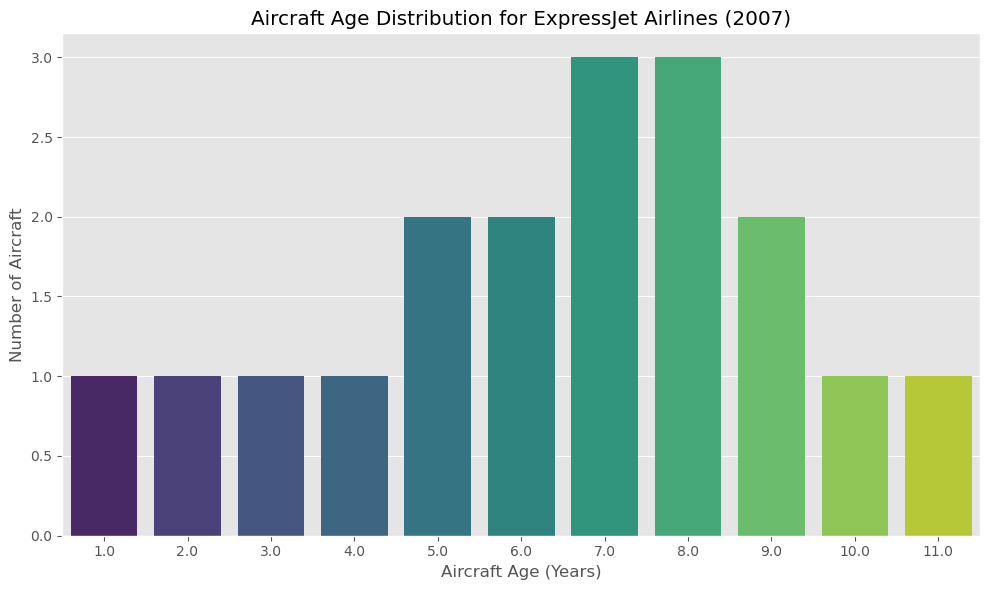

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Drop rows with missing age
age_data = df17.dropna(subset=['aircraft_age'])

# Count age frequencies
age_counts = age_data['aircraft_age'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=age_counts.index, y=age_counts.values, palette='viridis')
plt.title('Aircraft Age Distribution for ExpressJet Airlines (2007)')
plt.xlabel('Aircraft Age (Years)')
plt.ylabel('Number of Aircraft')
plt.tight_layout()
plt.show()


The bar chart indicates the distribution of aircraft ages in the ExpressJet Airlines fleet as of 2007. The data suggest that parts of ExpressJet’s carriers consist of a good number of aircrafts between 5 and 9 years old, especially at 7 and 8 years where each age had three aircraft. There are also two aircraft each at ages 5, 6, and 9. Altogether, these observations show that most of the fleet consists of aircraft in their mid-age years. In the aviation industry, an aircraft is generally considered to be mid-life between 6 to 15 years, with the global average fleet age typically ranging around 14 years depending on region and carrier type (Statista, 2023; International Air Transport Association [IATA], 2021).

On the newer aircraft side, it looks like there was one aircraft each at ages 1, 2, 3, and 4 years, which would indicate that there were newer models, but that also constitute a smaller amount of the total carriers. On the other end of the age scale, the older aircraft were 10 and 11 years, which also had one in each category.

This aircraft age distribution is valuable when considering the route cancellation rates associated with Newark Liberty International Airport (EWR) based on earlier graph. The fleet is around middle age, indicated that aging of an aircraft or wear on aircraft appear to be a key driver of cancellations noted. ExpressJet Airlines can be seen from this graph that they have problem in handling maintance and preparation for flight. 

Additionally, the cancellation issues appear also to be associated with other factors such as operational or external. External factors contributing to persistent cancellations could include congestion both on the ground and in the airspace around Newark Liberty International Airport (EWR), which is one of the busiest and most delay prone airports in the United States. Meteorological delays are also common in the Northeast U.S., especially during winter and summer months due to snowstorms and thunderstorms. In addition, inefficiencies in staffing or flight crew scheduling, as well as limitations in achieving timely aircraft turnaround, may further contribute to operational delays and cancellations (Federal Aviation Administration [FAA], 2023; Bureau of Transportation Statistics [BTS], 2022). Overall, the carriers ages within ExpressJet support the conclusion that although maintenance can always be a factor and it can be likely a key influencer for cancellation rate for flight on certain routes with EWR.

References.

International Air Transport Association. (2021). Aircraft Technology Roadmap to 2050. https://www.iata.org/en/iata-repository/publications/economic-reports/aircraft-technology-roadmap-to-2050

Statista. (2023). Average age of commercial aircraft fleet worldwide from 2015 to 2023. https://www.statista.com/statistics/865108/average-age-commercial-aircraft-fleet-world/

Federal Aviation Administration. (2023). FAA Aerospace Forecast: Fiscal Years 2023–2043. https://www.faa.gov/data_research/aviation/aerospace_forecasts

Bureau of Transportation Statistics. (2022). Airport On-Time Performance. https://www.transtats.bts.gov/OT_Delay/OT_DelayCause1.asp?pn=1

The high cancellation rates for ExpressJet Airlines on EWR related routes are a significant concern. However, when considering the aircraft age distribution for ExpressJet Airlines in 2007, it becomes clear that these cancellations are likely driven by an old carriers. The majority of their aircraft were in their middle operational years (5-9 years old) during that period. This suggests that the root cause of the high cancellation rates for EWR routes might lie in aircraft age with operational aspects such as maintenance protocols, crew scheduling, ground operations at EWR, or external factors like air traffic control delays and weather conditions that particularly impact EWR in itself.

Next, based on the table from problemmatic routes, let see the model and the manufacture of these carriers.

In [21]:
df13['model'].value_counts().head(10)

model
EMB-145LR      434
EMB-145EP      430
EMB-135ER      157
EMB-145XR       87
CL-600-2B19     75
EMB-145          5
EMB-135LR        3
Name: count, dtype: int64

In [38]:
df13['manufacturer'].value_counts()

manufacturer
EMBRAER           1116
BOMBARDIER INC      75
Name: count, dtype: int64

We can see the majority of the carrier are manufacture by EMBRAER where with the usual coding for their model start with EMB. Next, we see the relation between the models and the routes that the model is used.

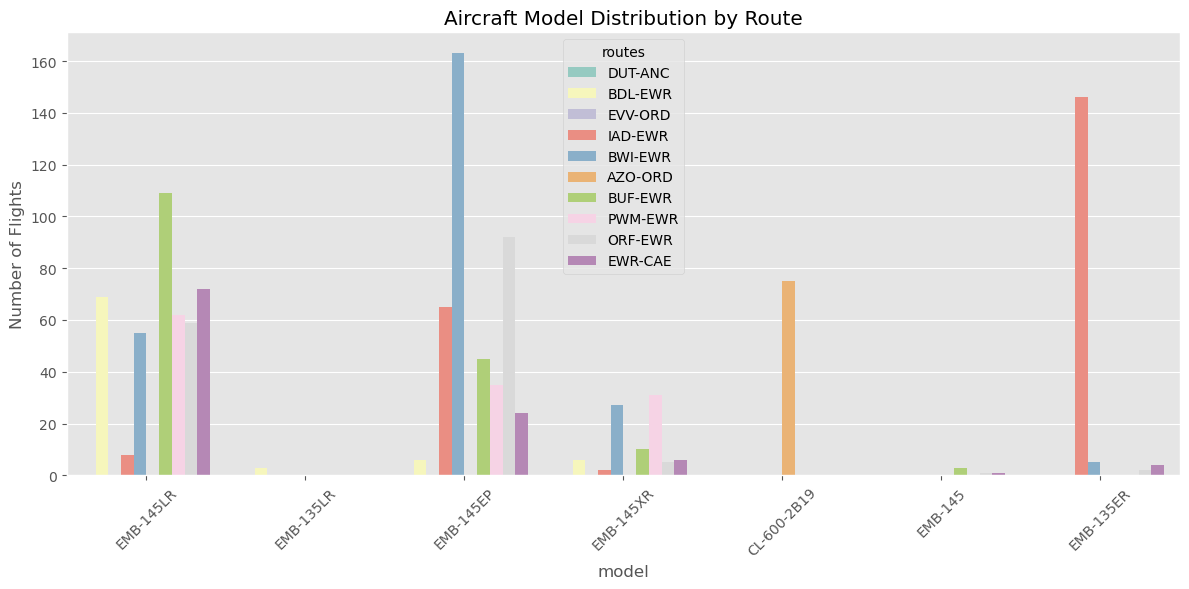

In [23]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df13, x='model', hue='routes', palette='Set3')
plt.xticks(rotation=45)
plt.title('Aircraft Model Distribution by Route')
plt.ylabel('Number of Flights')
plt.tight_layout()
plt.show()


The analysis of aircraft models across several key airline routes reveals a distinct pattern in carrier deployment. The most frequently used aircraft models are the EMB-145LR, EMB-145EP, and EMB-135ER, which collectively account for the majority of flights across the examined routes. Other models, such as the EMB-135LR, EMB-145XR, CL-600-2B19, and EMB-145, are used less frequently and appear to serve more specialized or limited roles.

Aircraft deployment varies significantly by route, suggesting that airlines tailor their carrier choices to match route specific demands. For example, the EMB-145LR is the preferred model for the BUF–EWR route, accounting for over 100 flights, and is also commonly used on EWR–CAE, BDL–EWR, and BWI–EWR. In contrast, the EMB-135ER stands out as the dominant model on the IAD–EWR route with over 140 flights, indicating its importance in serving that corridor.

The EMB-145EP demonstrates a particularly strong presence on the BWI–EWR route, with over 160 flights which is the highest number observed for any model on a single route in this analysis. This suggests that the EMB-145EP may be the most used flights for this route thus creating a huge delay in managing the flights since the dependecies on one carriers alone. It is also used on IAD–EWR, BUF–EWR, and ORF–EWR, though to a lesser extent.

Interestingly, the CL-600-2B19 is used almost exclusively on the BWI–EWR route, representing about 75 flights. This may indicate a route specific operational strategy or reflect aircraft availability within the airline's carriers. Similarly, the EMB-145XR is primarily deployed on the BWI–EWR route and PWM–EWR, suggesting targeted utilization based on aircraft performance or route characteristics.

In summary, this aircraft usage distribution highlights that airlines, particularly ExpressJet, rely heavily on a few key aircraft models to operate their high frequency routes. Carrier decisions appear to be influenced by factors such as aircraft range, seating capacity, fuel efficiency, and airport characteristics (Federal Aviation Administration [FAA], 2023). These deployment strategies also underscore how route planning is tightly linked to carriers composition, with some aircraft models being concentrated on specific routes due to their operational advantages.

References.

Federal Aviation Administration. (2023). FAA Aerospace Forecast: Fiscal Years 2023–2043. https://www.faa.gov/data_research/aviation/aerospace_forecasts

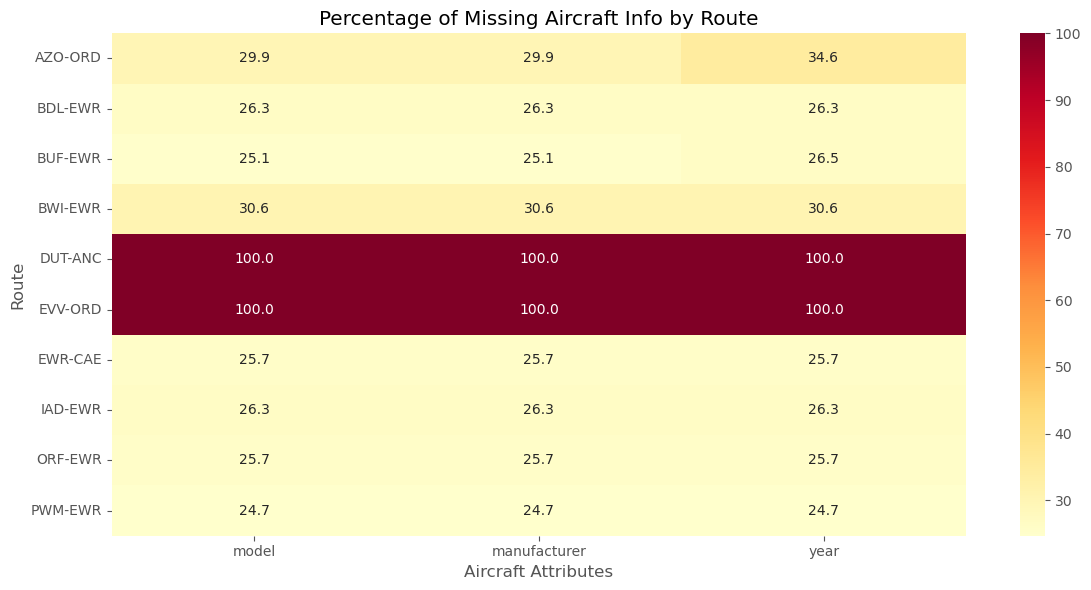

In [30]:
# Total rows per route
route_counts = df13.groupby('routes').size()

# Missing summary (as before)
missing_heatmap = df13[['model', 'manufacturer', 'year']].isnull()
missing_summary = missing_heatmap.groupby(df13['routes']).sum()

# Calculate % missing
missing_percent = missing_summary.div(route_counts, axis=0) * 100

plt.figure(figsize=(12, 6))
sns.heatmap(missing_percent, annot=True, fmt='.1f', cmap='YlOrRd')
plt.title('Percentage of Missing Aircraft Info by Route')
plt.xlabel('Aircraft Attributes')
plt.ylabel('Route')
plt.tight_layout()
plt.show()

This heatmap presents the percentage of missing aircraft information including model, manufacturer, and year for selected airline routes. Each cell shows how much of that particular attribute is missing for a given route. The visual clearly highlights discrepancies in aircraft data coverage across different routes.

The most critical observation is that two routes, DUT–ANC and EVV–ORD, have 100% missing values for all aircraft attributes. This suggests a complete absence of aircraft metadata for these flights, likely due to unmatched or invalid TailNum entries during the merge with the aircraft dataset. These routes may involve special operational conditions, such as chartered flights, regional operators not captured in the dataset, or errors in aircraft registration records.

For most other routes, including BWI–EWR, AZO–ORD, BDL–EWR, and BUF–EWR, the proportion of missing data is moderately high, ranging from about 25% to 35%. The missingness appears consistent across model, manufacturer, and year, implying that a subset of flights likely had no associated TailNum, or the TailNum was recorded in an incompatible format that prevented a successful merge.

The route with the least missing data is PWM–EWR, at approximately 24.7%, but even this suggests nearly a quarter of aircraft records are incomplete. This indicates a broader systemic issue with the aircraft metadata in the dataset, particularly for ExpressJet Airlines routes.

To address these issues, one suggestion is to audit the TailNum field for inconsistencies such as null values, blank strings, or unusual patterns. Verifying and cleaning these values may help recover lost metadata. Where possible, external aircraft registration databases (such as those provided by the FAA or BTS) could be used to cross reference and supplement missing information.

In conclusion, while the dataset provides valuable insight into aircraft usage patterns, the gaps in aircraft information present limitations that must be addressed either through external data supplementation or thoughtful data cleaning strategies.

## Conclusion

This project has provided a comprehensive analysis of airline performance using the 2007 dataset from the U.S. Department of Transportation. By exploring flight cancellations, delays, and aircraft data, several critical insights were uncovered. Routes involving Newark Liberty International Airport (EWR), particularly those operated by ExpressJet Airlines Inc., consistently showed the highest cancellation rates and significant departure delays which indicate systemic operational inefficiencies or infrastructure constraints at EWR. Temporal patterns revealed that cancellations were most frequent in the afternoon and during winter months, often influenced by weather events and scheduling congestion. Aircraft data analysis suggested that while the carriers age was mid age, incomplete metadata limited deeper diagnostics. The dominant causes of cancellations were linked to airline carriers, followed by weather, NAS (National Airspace System), and rare security events. These findings underscore the importance of route specific analysis, carrier performance monitoring, and operational preparedness especially in high traffic hubs to improve airline reliability and customer experience. Future recommendations include enhancing data quality, leveraging real time weather data, and revisiting scheduling strategies for vulnerable routes and peak periods.